## Carga librerias

In [5]:
import pandas as pd
import numpy as np
import math
from scipy.stats import randint, uniform

# plots
import matplotlib.pyplot as plt
# %matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

# misc
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# Summary stats
import skimpy as sk

### Import Models

In [6]:
# MODELS
from sklearn.metrics import root_mean_squared_error

# models
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components
# Prophet evaluation
from prophet.diagnostics import cross_validation, performance_metrics

## Carga datos

In [7]:
from modules import load_data as m_ld

In [8]:
# Carga de diccionario
df = m_ld.load_data('sales_by_department_shop_with_events.csv')

display(df.head())

fecha  ejercicio  mes  semana store_code       category  \
0  2011-01-29       2011    1       4      BOS_1     ACCESORIES   
1  2011-01-29       2011    1       4      BOS_1     ACCESORIES   
2  2011-01-29       2011    1       4      BOS_1  HOME_&_GARDEN   
3  2011-01-29       2011    1       4      BOS_1  HOME_&_GARDEN   
4  2011-01-29       2011    1       4      BOS_1    SUPERMARKET   

        department  unidades    cifra  region      store  latitud  longitud  \
0     ACCESORIES_1     241.0   951.95  Boston  South_End  42.3389  -71.0728   
1     ACCESORIES_2      10.0    58.83  Boston  South_End  42.3389  -71.0728   
2  HOME_&_GARDEN_1     418.0  1633.15  Boston  South_End  42.3389  -71.0728   
3  HOME_&_GARDEN_2     106.0   712.49  Boston  South_End  42.3389  -71.0728   
4    SUPERMARKET_1     152.0   482.98  Boston  South_End  42.3389  -71.0728   

  event  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN

# INFORME

In [9]:
# Convertimos 'fecha' a date
df['fecha'] = pd.to_datetime(df['fecha'], format = '%Y-%m-%d')

# Rellenamos events Nan con 'None'
df['event'] = df['event'].fillna(value='None')

# Aseguramos orden por fecha del df
df = df.sort_values('fecha',ascending=True)

# Encontrar la fecha mínima y máxima
min_date = df['fecha'].min()
max_date = df['fecha'].max()

# Calcular la diferencia en días
days_diff = (max_date - min_date).days + 1  # +1 para incluir ambos extremos

# Calcular la diferencia en meses
months_diff = round(days_diff / 30.5)  # Asumiendo un mes promedio de 30.5 días

print(f"Fecha mínima: {min_date}")
print(f"Fecha máxima: {max_date}")
print(f"Días de datos analizados: {days_diff}")
print(f"Meses de datos analizados: {months_diff}")
print(f"Fechas unicas que tenemos: {df['fecha'].nunique()}")
print(f"¿Faltan fechas?: {days_diff - df['fecha'].nunique()}")

Fecha mínima: 2011-01-29 00:00:00
Fecha máxima: 2016-04-24 00:00:00
Días de datos analizados: 1913
Meses de datos analizados: 63
Fechas unicas que tenemos: 1913
¿Faltan fechas?: 0


In [10]:
# Añadimos nombre del dia al df
df['dia'] = df['fecha'].dt.day_name()

# Vemos primer y último día
print(f'1er dia de nuestros datos: {df["dia"].iloc[0]}')
print(f'Ultimo dia de nuestros datos: {df["dia"].iloc[-1]}')

1er dia de nuestros datos: Saturday
Ultimo dia de nuestros datos: Sunday


In [11]:
# Añadimos numero de dia de la semana
df['dia_semana'] = df['fecha'].dt.dayofweek

In [12]:
# Skim describe
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 133547 │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 16     │ │ int32       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 4     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0      ┃ p25     ┃ p50     ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ ejercicio     │   0 │     0 │     2013 │   1.532 │    2011 │    2012 │    2013 │   2015 │    2016 │ ▇▇▇▇▇▃ │  │
│ │ mes           │   0 │     0 │    6.344 │   3.452 │       1 │       3 │       6 │      9 │      12 │ ▇▇▇▇▇▇ │  │
│ │ semana        │   0 │     0 │    25.81 │   15.09 │       1 │      12 │      25 │     39 │      53 │ ▇▇▆▇▇▆ │  │
│ │ unidades      │   0 │     0 │    491.9 │   602.9 │       1 │     136 │     287 │    551 │    5118 │   ▇▁   │  │
│ │ cifra         │   0 │     0 │     1730 │    1665 │    0.27 │   618.5 │    1230 │   2359 │   13440 │  ▇▂▁   │  │
│ │ latitud       │   0 │     0 │    40.98 │  0.9454 │   39.94 │   39.98 │   40.73 │  42.32 │   42.35 │ ▇▇▃  ▇ │  │
│ │ longitud      │   0 │     0 │   -73.46 │   1.631 │  -75.16 │  -75.15 │  -73.95 │  -71.1 │  -71.07 │ ▆▇   ▆ │  │
│ │ dia_semana    │   0 │     0 │    3.002 │   2.001 │       0 │       1 │       3 │      5 │       6 │ ▃▃▃▃▃▇ │  │
│ └───────────────┴─────┴───────┴──────────┴─────────┴─────────┴─────────┴─────────┴────────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ fecha                  │      0 │         0 │     2011-01-29      │     2016-04-24      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ store_code                │       0 │          0 │                            1 │                   133547 │  │
│ │ category                  │       0 │          0 │  

In [13]:
# Evolucion numero de productos por año
from sqlalchemy import create_engine
import sqlalchemy
import mysql
import os
from dotenv import load_dotenv

load_dotenv()

PASSWORD = os.getenv('SQL.LOCAL.PASS')

if PASSWORD:
    user = 'root'
    password  = PASSWORD
    host= 'localhost'
    bbdd = 'dsmarket'
    cadena_conexion=f"mysql+mysqlconnector://{user}:{password}@{host}/{bbdd}"
else:
    print('SQL PASS NOT FOUND')

def get_df(table):
    try:
        motor = create_engine(cadena_conexion)
        consulta = f'SELECT * FROM {table}'
        df = pd.read_sql_query(consulta, motor)
        print(f"{table} cargada")
        return df
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [14]:
df_items_sales_w = get_df('vensem')

vensem cargada


In [15]:
df_items_sales_w.head()

item store_code  ejercicio  semana  unidades  sell_price  cifra
0  ACCESORIES_1_004      BOS_1       2011       4       3.0        5.77  17.32
1  ACCESORIES_1_004      BOS_2       2011       4       8.0        5.77  46.18
2  ACCESORIES_1_004      NYC_2       2011       4       9.0        5.77  51.95
3  ACCESORIES_1_004      NYC_4       2011       4       2.0        5.77  11.54
4  ACCESORIES_1_004      PHI_1       2011       4       3.0        5.77  17.32

In [18]:
# # Evolucion numero de productos por año
# # Contar productos únicos por año
unique_items_per_year = df_items_sales_w.groupby('ejercicio')['item'].nunique()

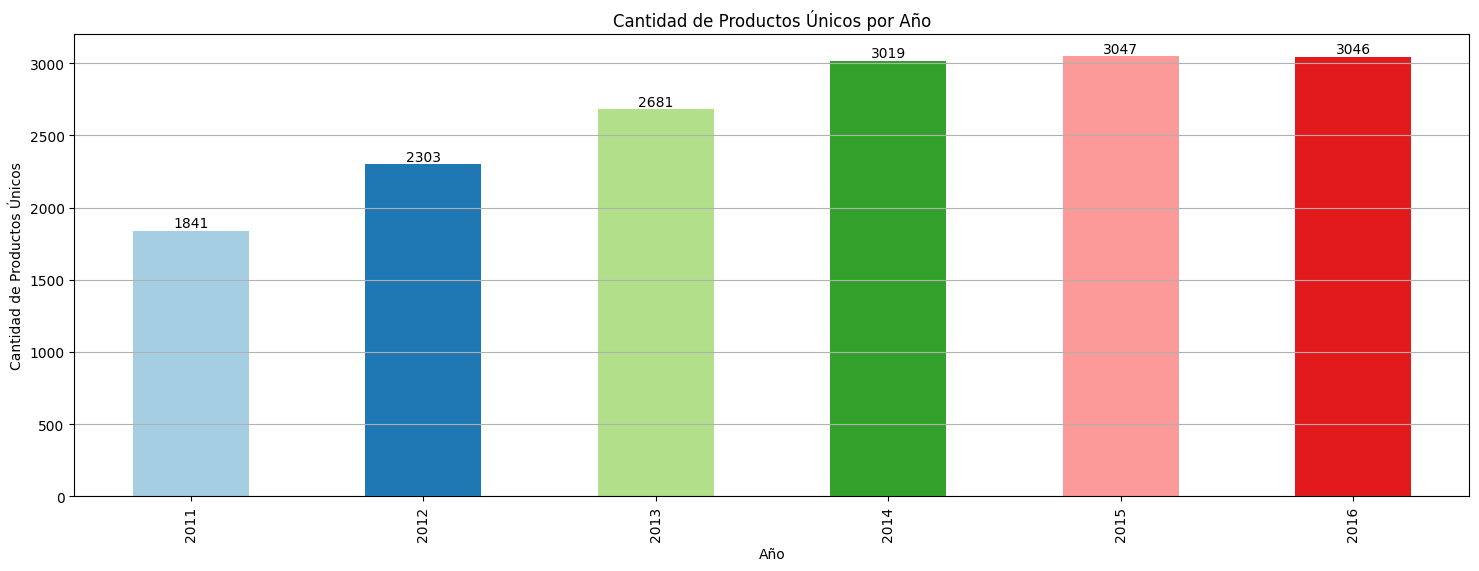

In [19]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(18, 6))

# Crear el gráfico de barras
bars = unique_items_per_year.plot(kind='bar', color=plt.cm.Paired(range(len(unique_items_per_year))))

# Título y etiquetas
plt.title('Cantidad de Productos Únicos por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Productos Únicos')

# Mostrar el total de items únicos encima de cada barra
for index, value in enumerate(unique_items_per_year):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Mostrar el gráfico
plt.grid(True, axis='y')
plt.show()

# Time Series analisis

In [20]:
from modules import time_series_analisis as tma

## Evolucion ventas diarias

In [21]:
# Obtenemos lista de regiones
regions = df['region'].unique().tolist()

# Obtenemos lista de tiendas
store_code = df['store_code'].unique().tolist()

# Obtenemos lista de departamentos
categories = df['category'].unique().tolist()

# Obtenemos lista de departamentos
department = df['department'].unique().tolist()

In [22]:
# Filtramos df por los 2 últimos años
df_origin = df.copy() # Copia para no perder original

df = df[df['ejercicio'].isin([2014, 2015, 2016])]

### Por tiendas de region

Generando gráfico para la región: Boston


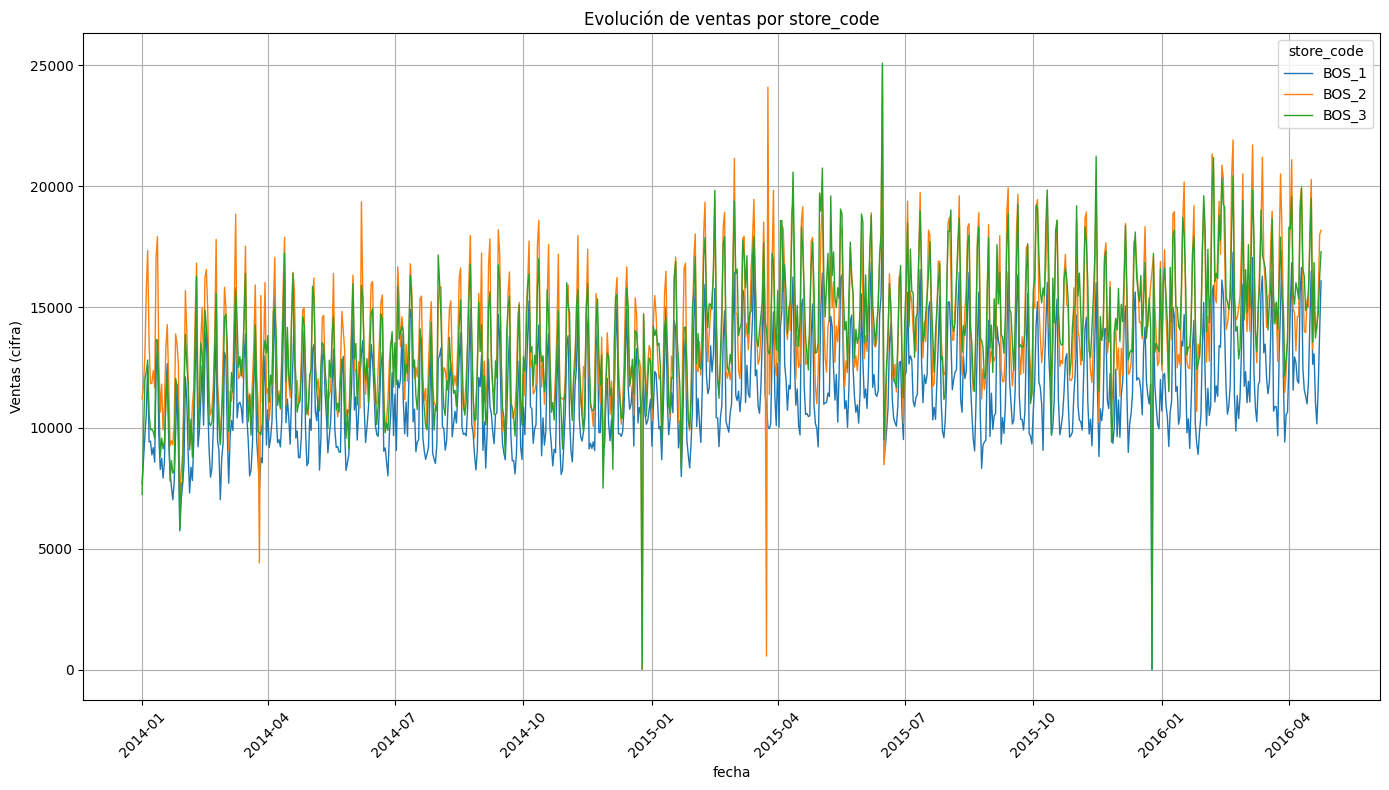

Generando gráfico para la región: New York


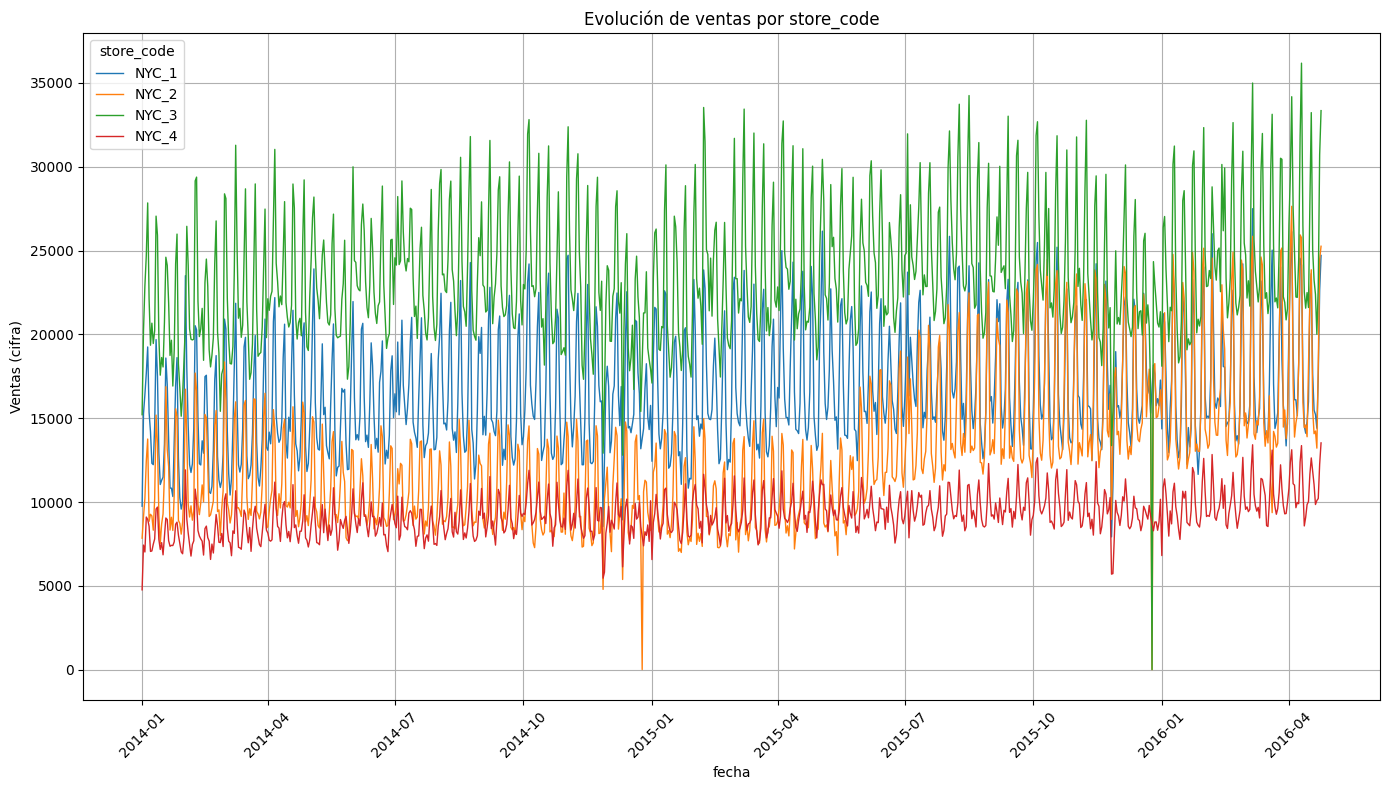

Generando gráfico para la región: Philadelphia


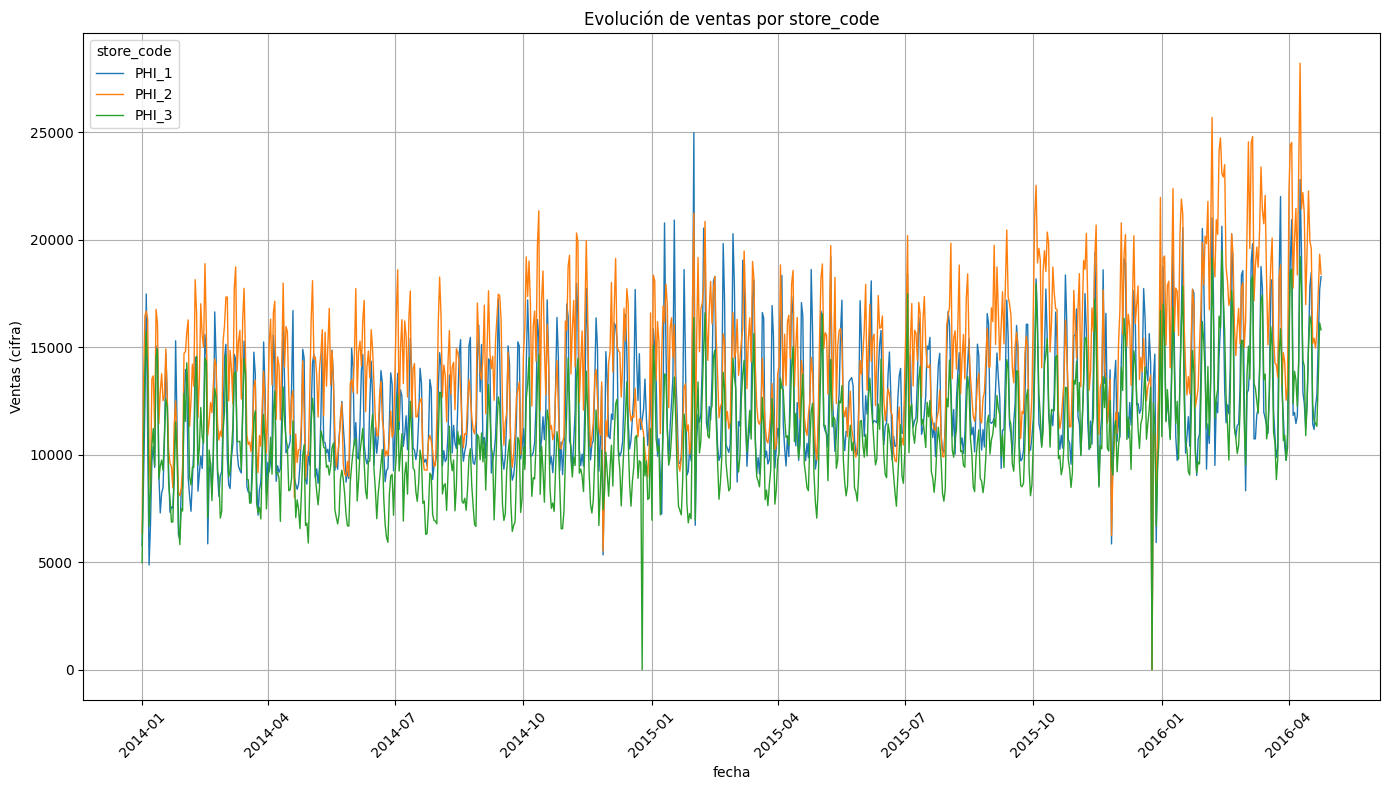

In [23]:
# Vemos graficas ventas por tiendas / regiones
# Para verlo más claro filtramos el df por regiones y vemos las ventas de tiendas de cada region
for region in regions:
    # Filtrar por la región actual
    _df = tma.filter_data(df, 'region', region)
    
    # Llamar a la función de graficar
    print(f"Generando gráfico para la región: {region}")
    tma.plot_sales(_df, 'store_code')


### Por tiendas

Generando gráfico para la tienda: BOS_1


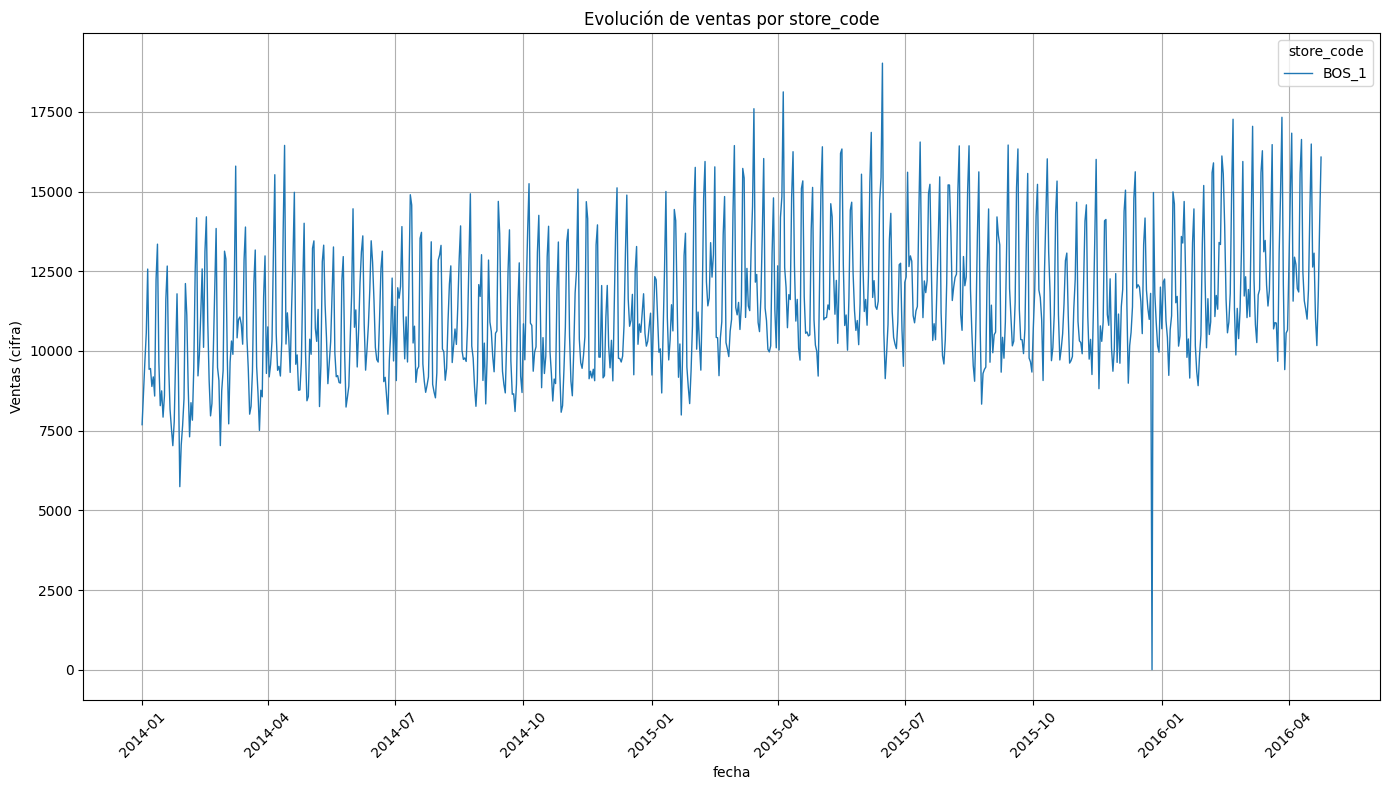

Generando gráfico para la tienda: NYC_3


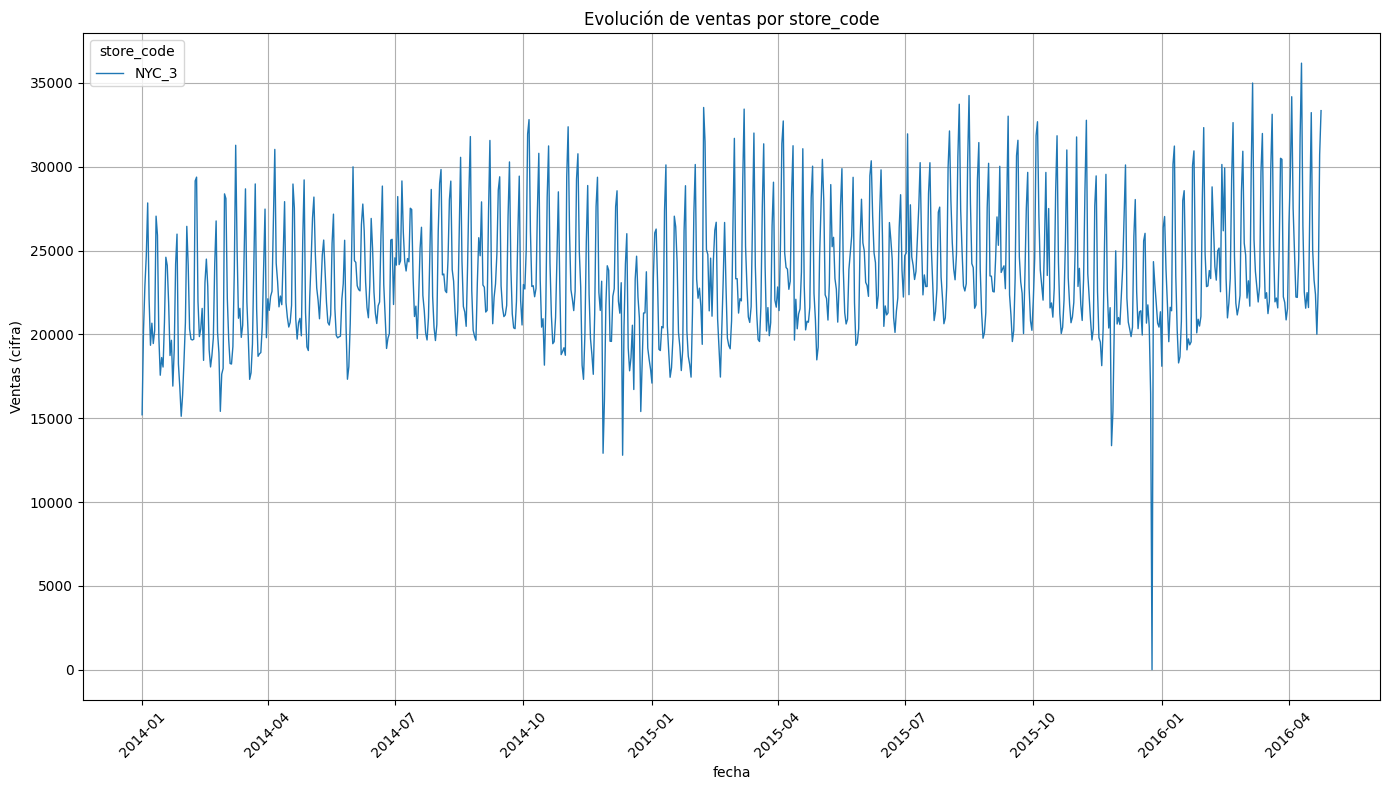

Generando gráfico para la tienda: NYC_4


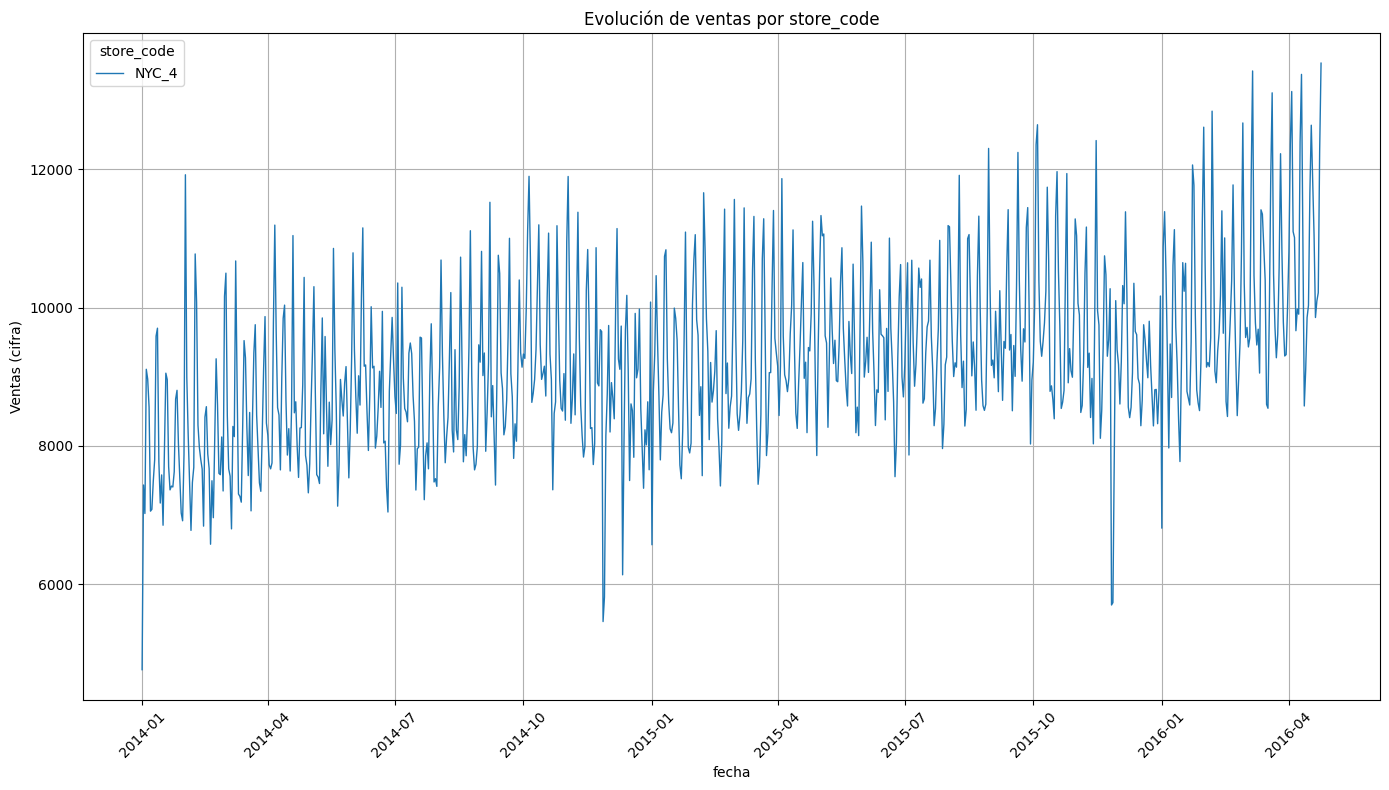

Generando gráfico para la tienda: PHI_1


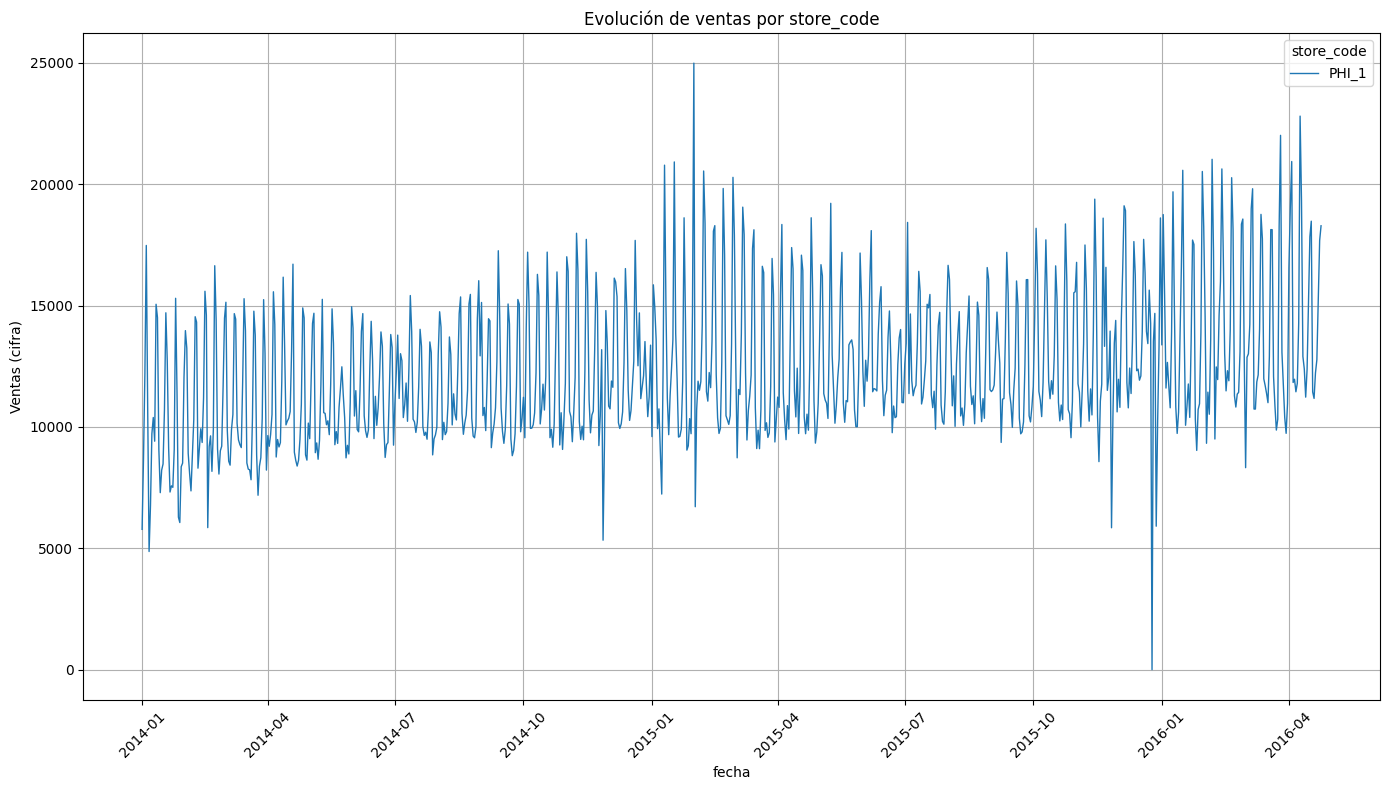

Generando gráfico para la tienda: PHI_3


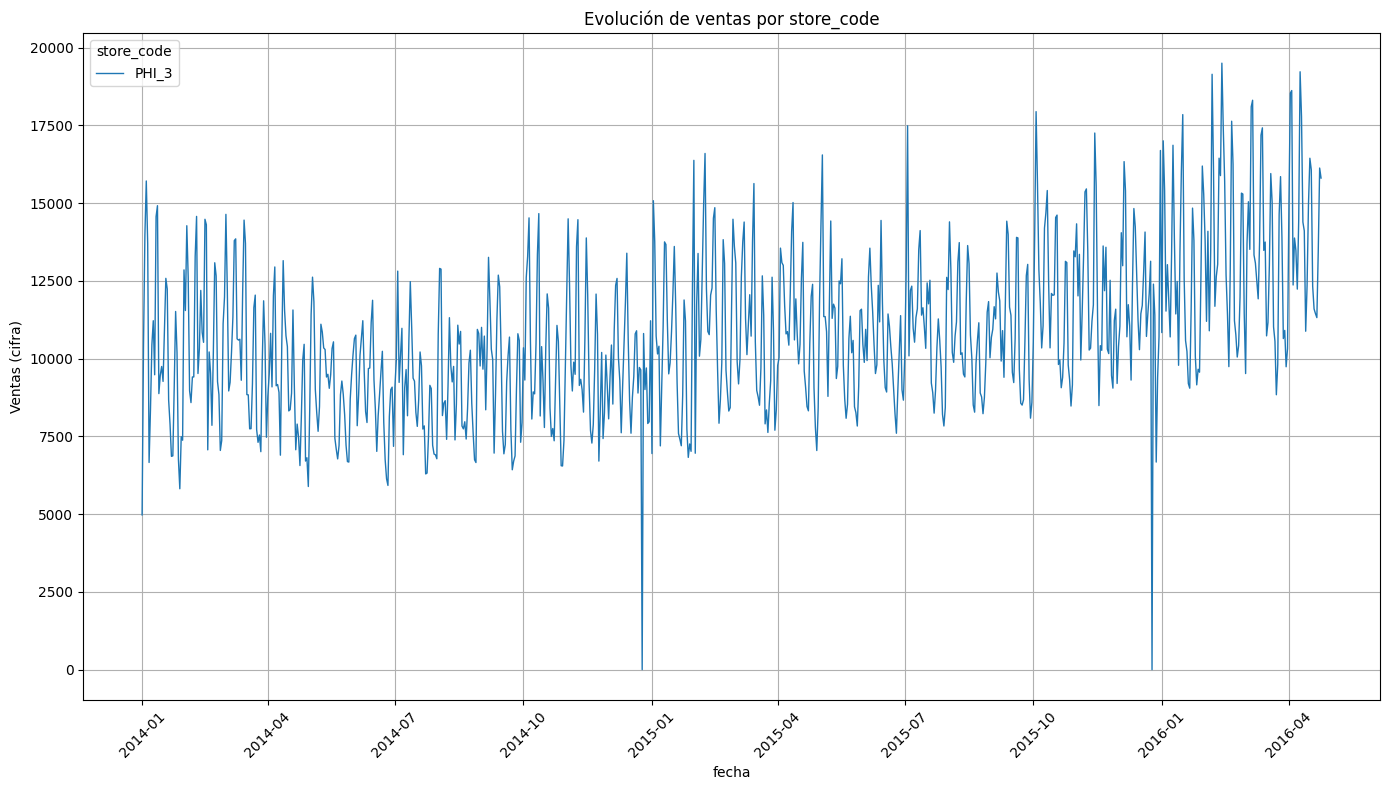

Generando gráfico para la tienda: PHI_2


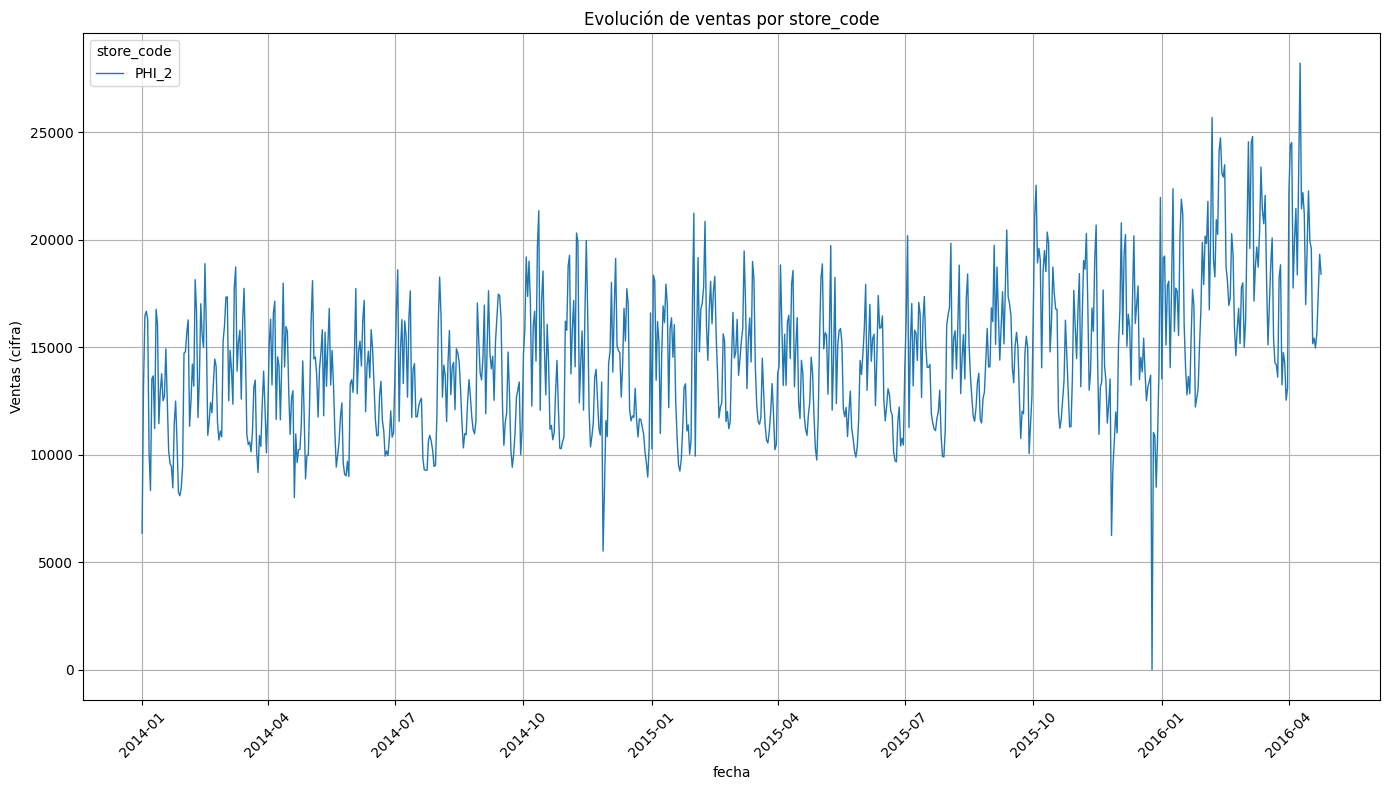

Generando gráfico para la tienda: NYC_2


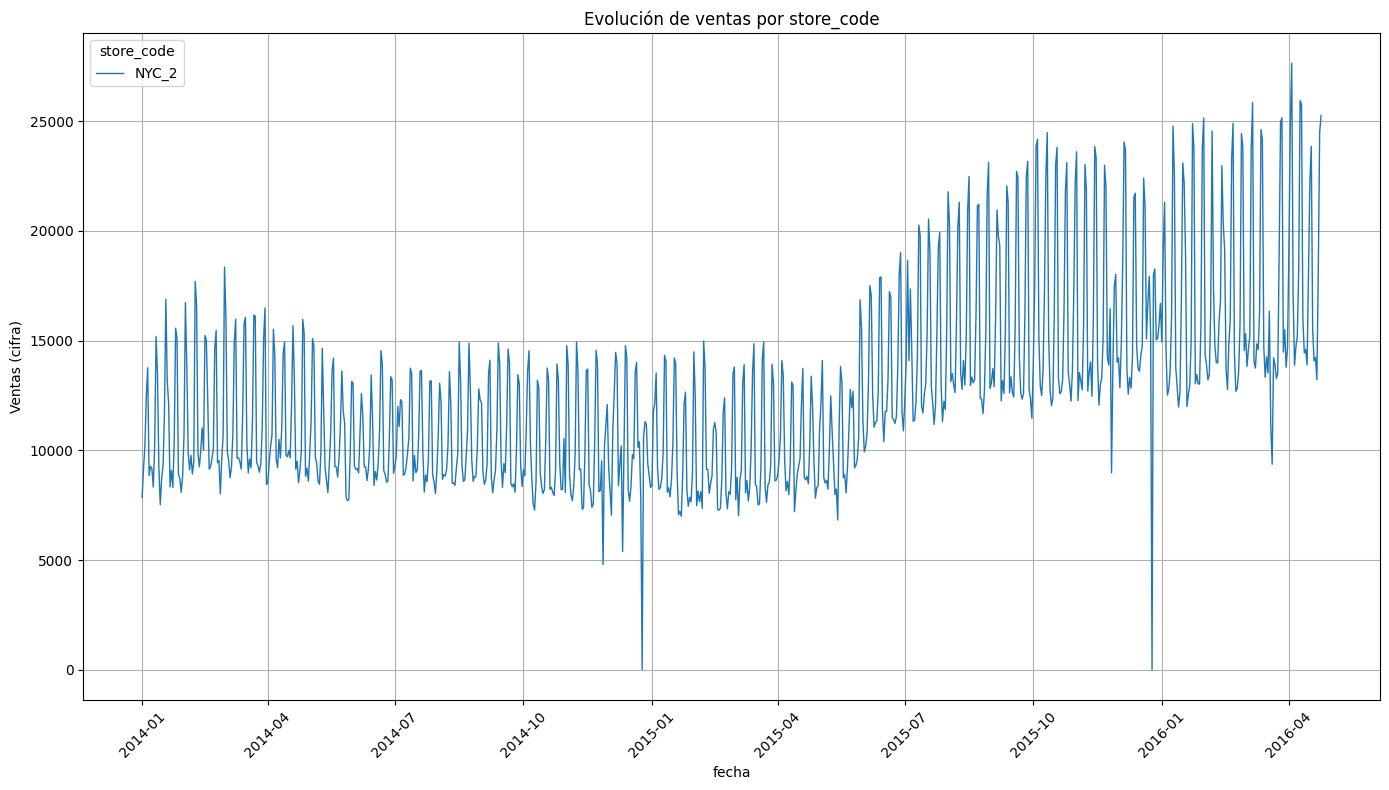

Generando gráfico para la tienda: BOS_3


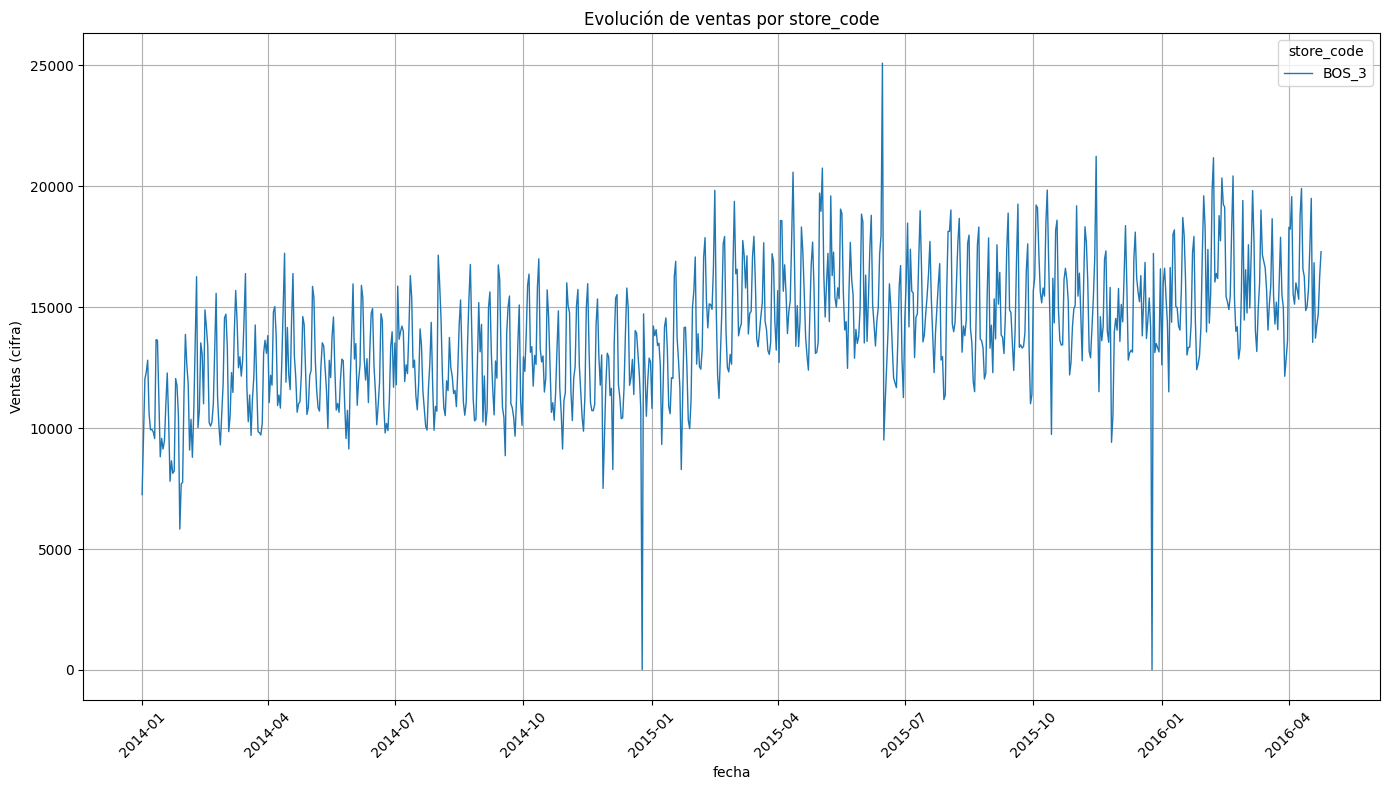

Generando gráfico para la tienda: BOS_2


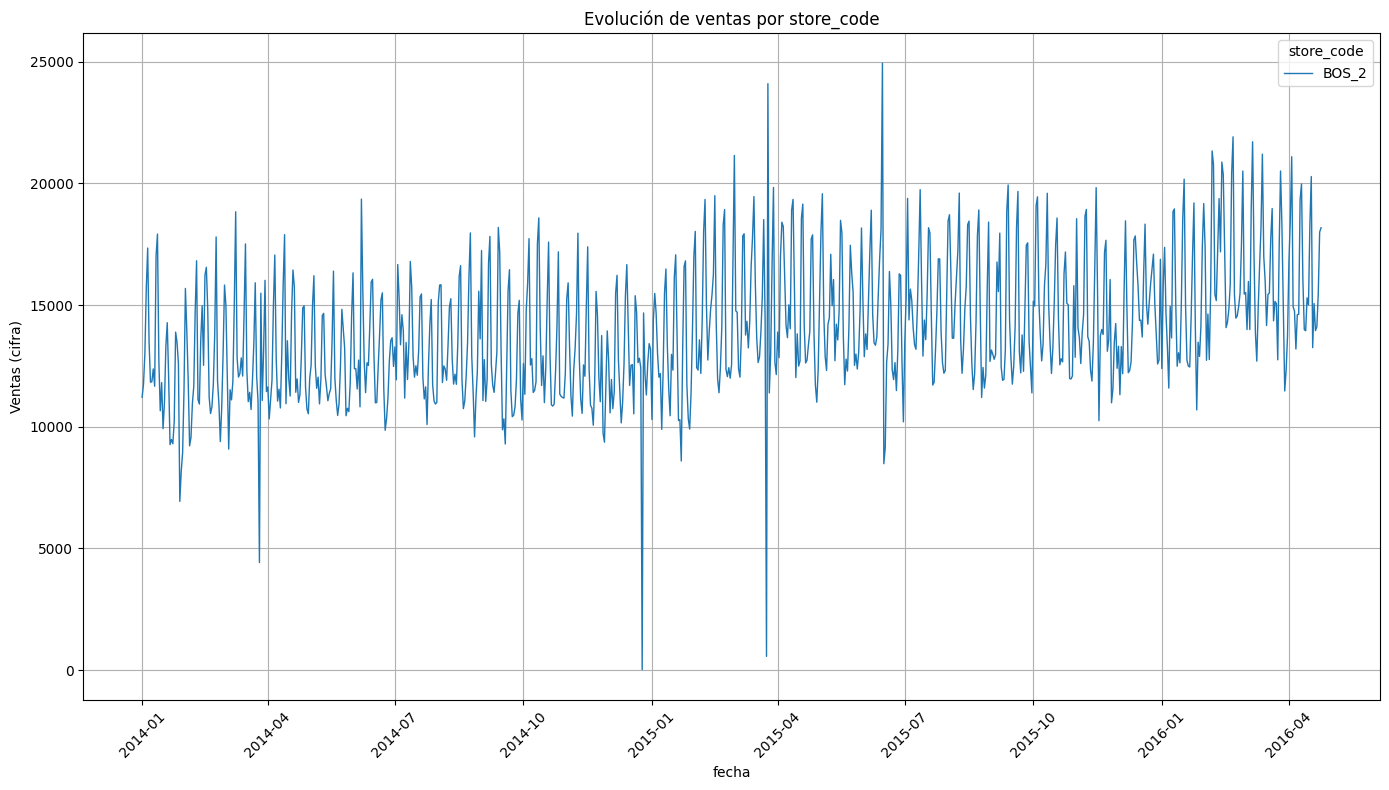

Generando gráfico para la tienda: NYC_1


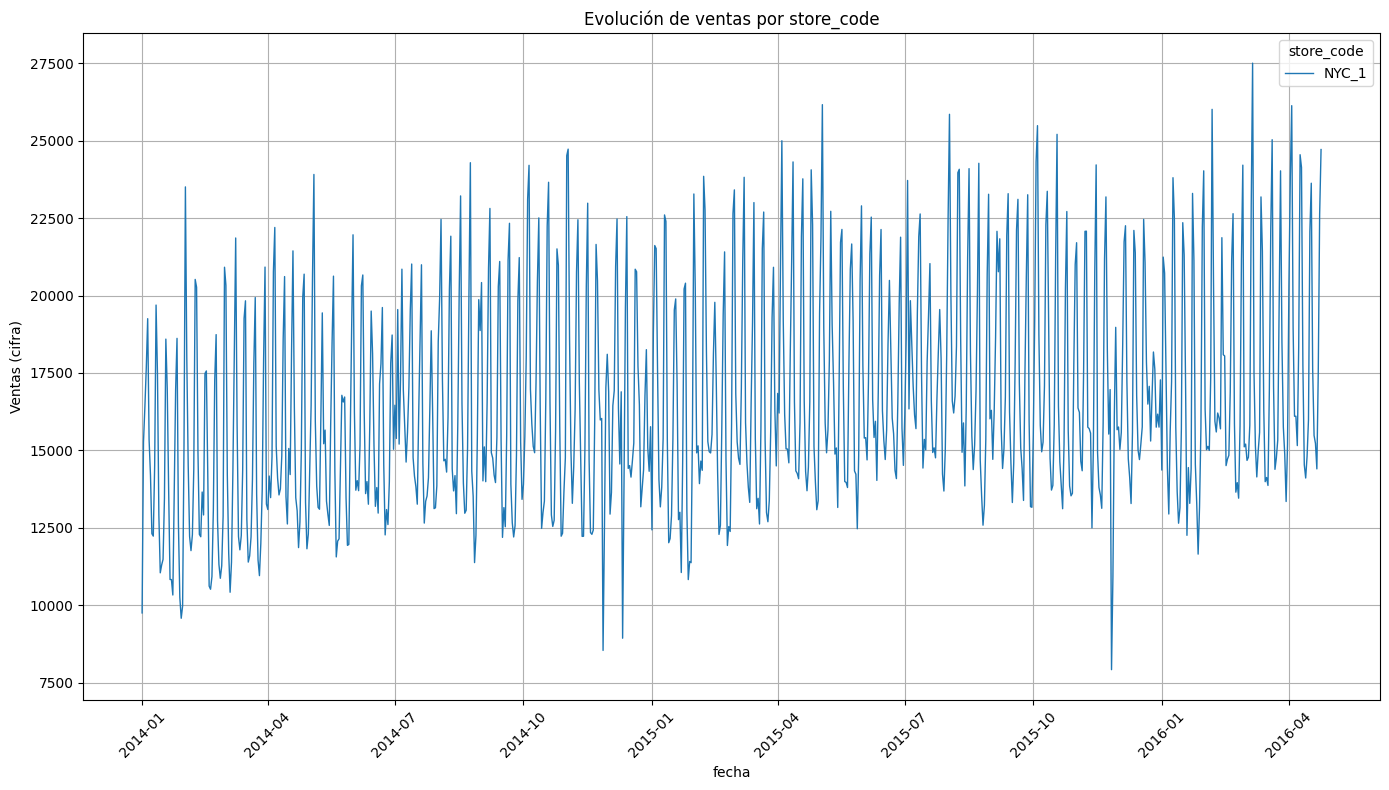

In [24]:
# Vemos graficas ventas por tiendas
# Para verlo más claro filtramos el df por tiendas
for store in store_code:
    # Filtrar por la región actual
    _df = tma.filter_data(df, 'store_code', store)
    
    # Llamar a la función de graficar
    print(f"Generando gráfico para la tienda: {store}")
    tma.plot_sales(_df, 'store_code')


### Por departamentos de categorias

Generando gráfico para la categoria: ACCESORIES


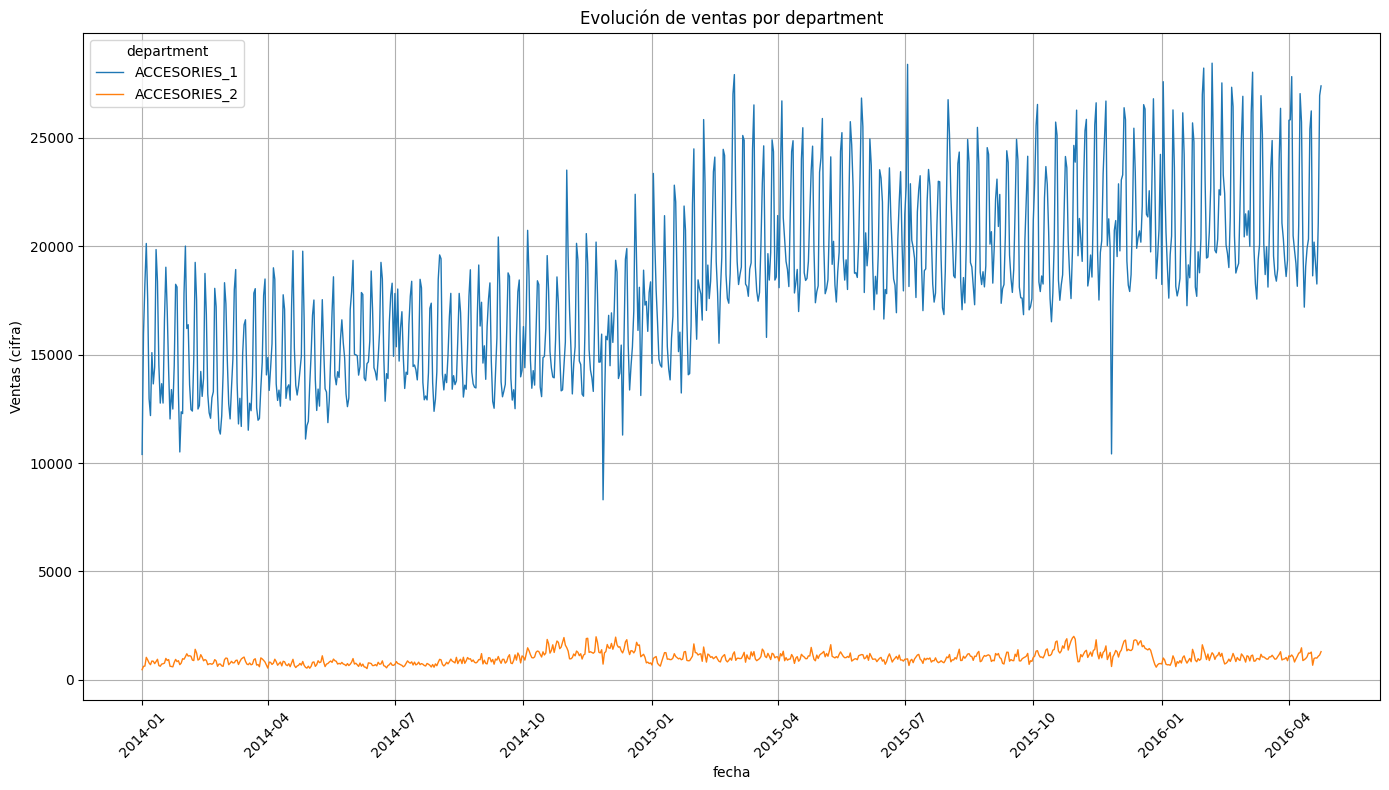

Generando gráfico para la categoria: HOME_&_GARDEN


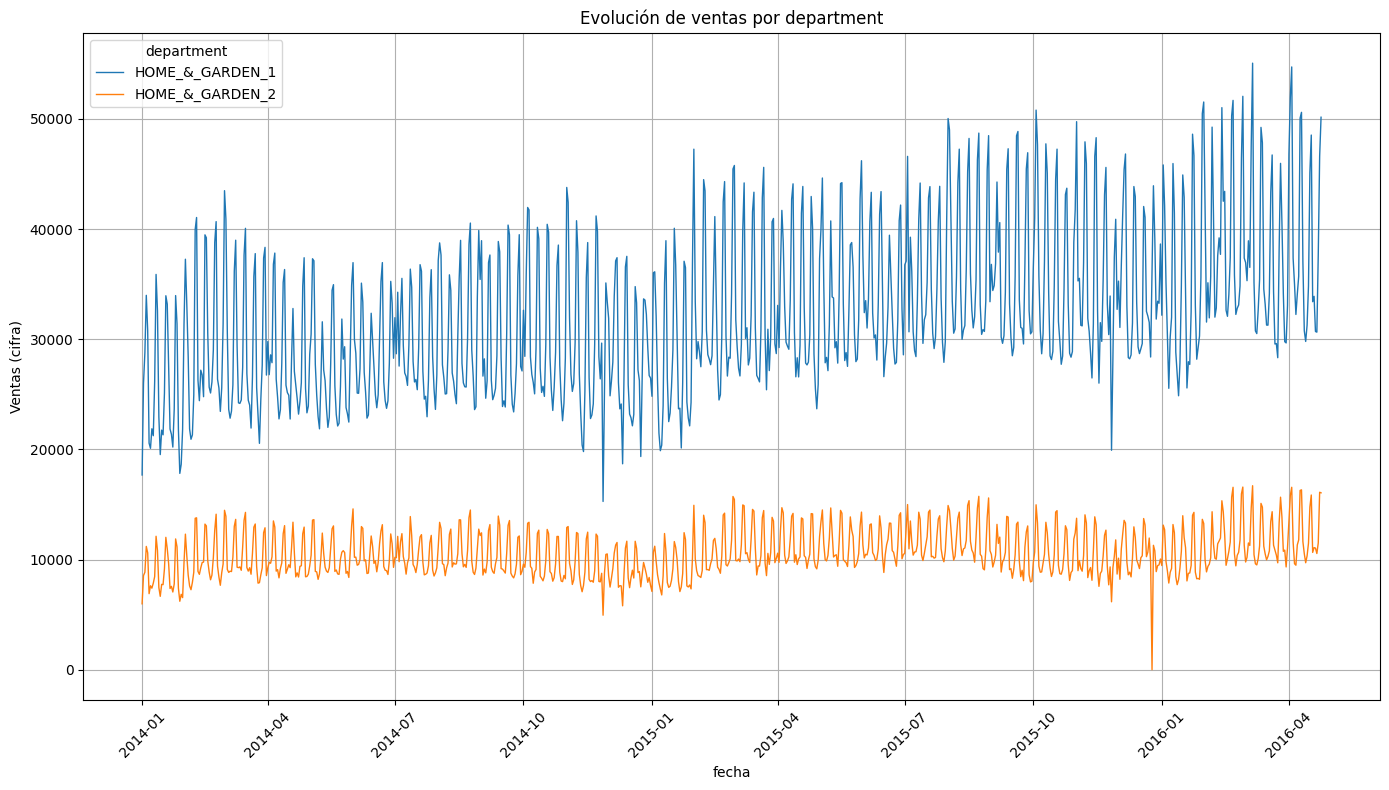

Generando gráfico para la categoria: SUPERMARKET


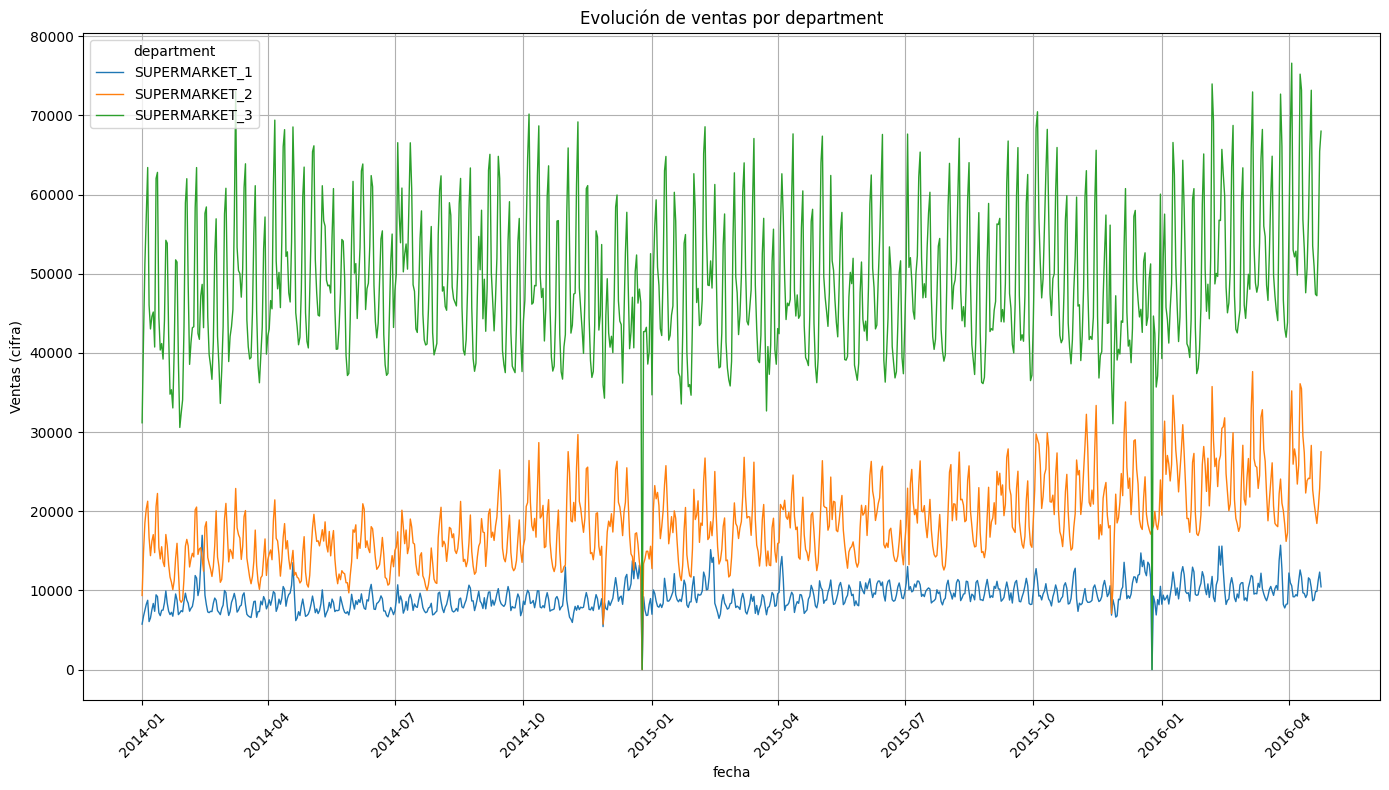

In [25]:
# Vemos graficas ventas por departamentos
# Para verlo más claro filtramos el df por categorias y vemos las ventas de departamentos de cada una
for category in categories:
    # Filtrar por la categoria actual
    _df = tma.filter_data(df, 'category', category)
    
    # Llamar a la función de graficar
    print(f"Generando gráfico para la categoria: {category}")
    tma.plot_sales(_df, 'department')

## Outliers

Parece que hay varios momentos en los que las ventas son 0. **¿Qué hacemos?**

## Descomposicion series temporales

### TIENDAS

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: BOS_1
______________________________________________________________________________________________


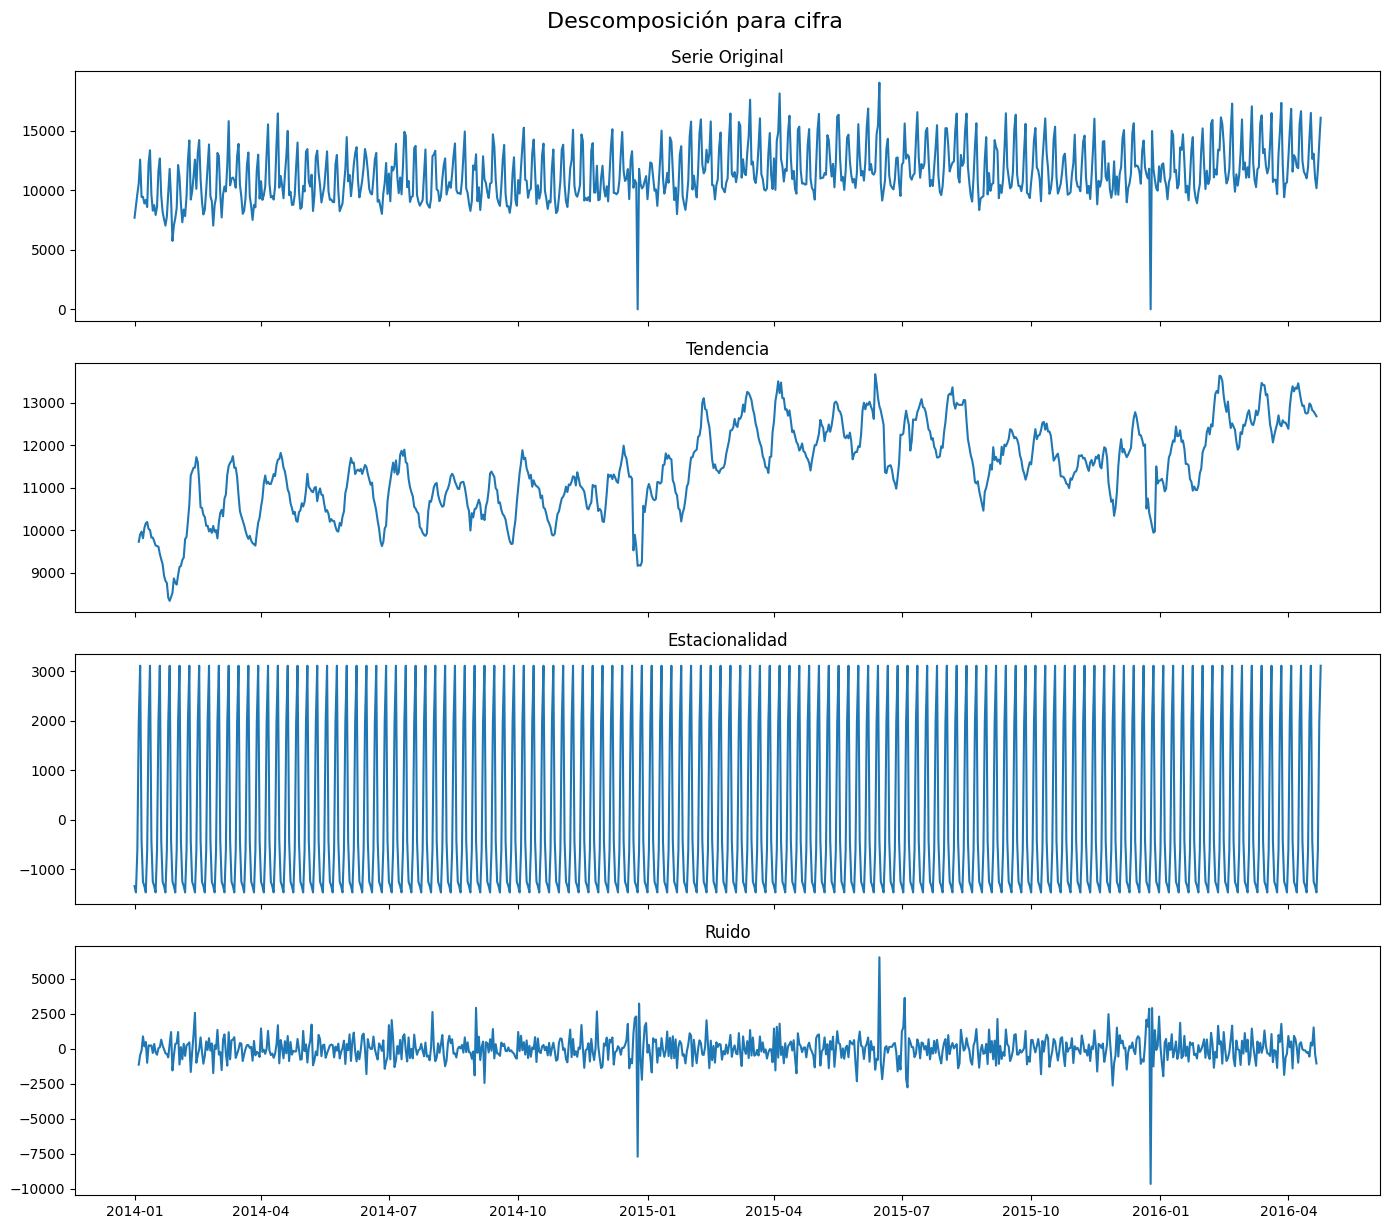

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: NYC_3
______________________________________________________________________________________________


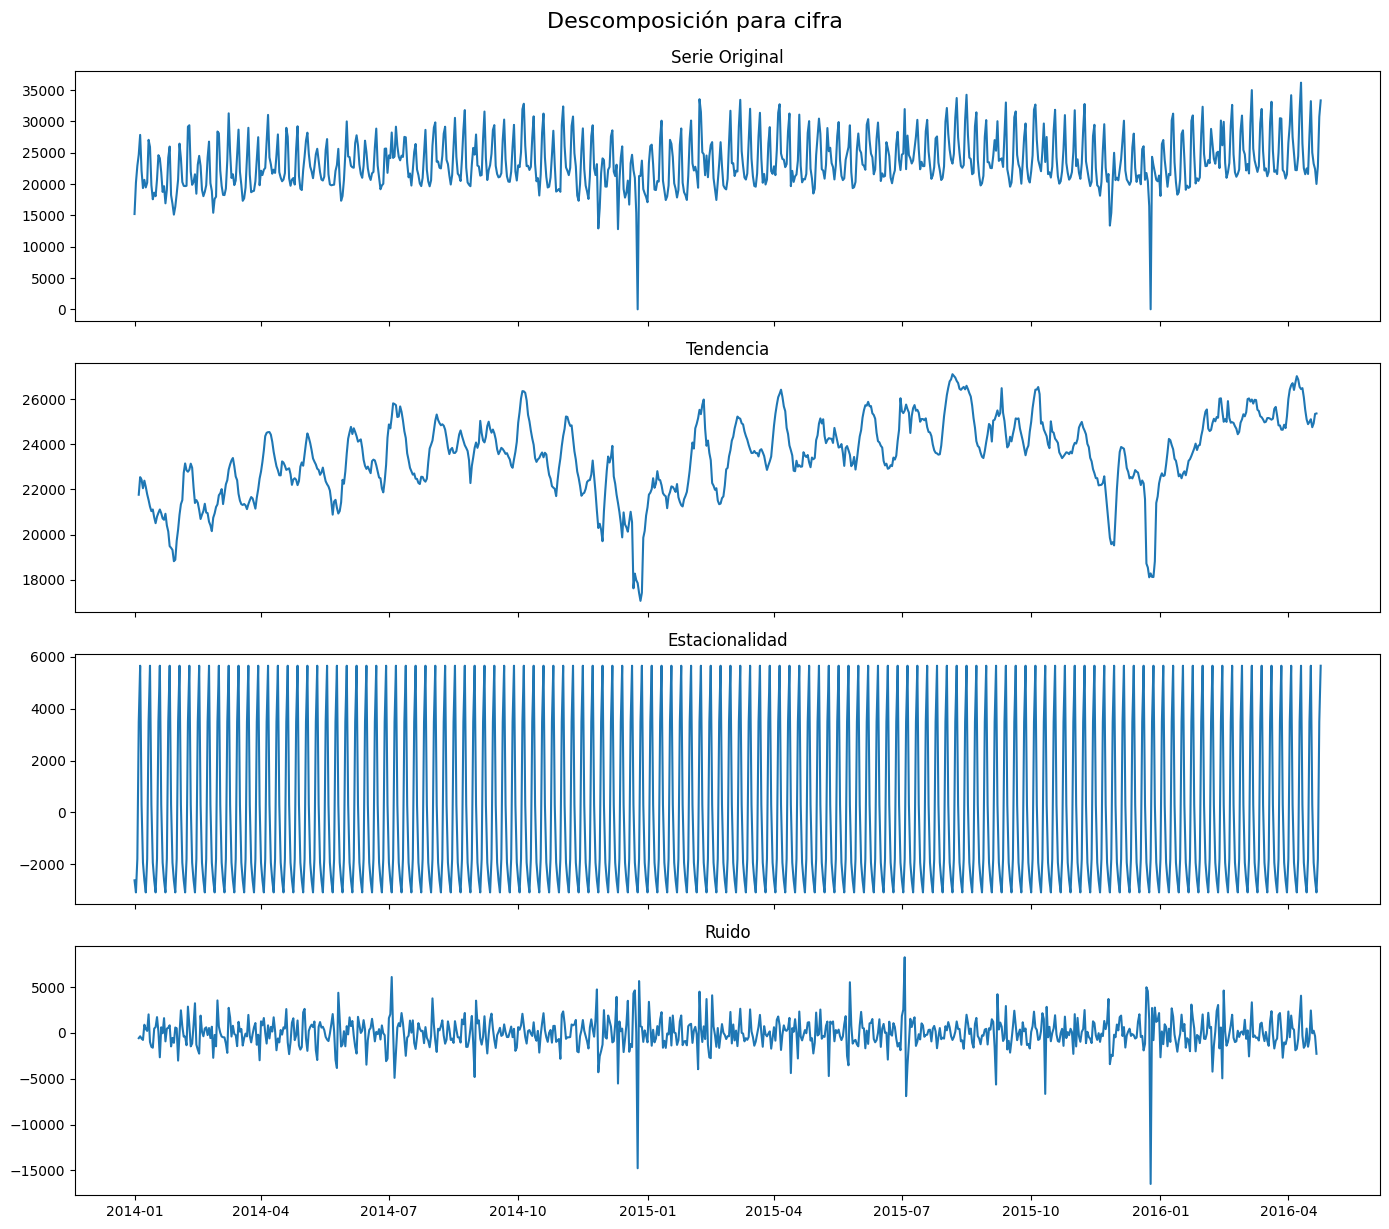

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: NYC_4
______________________________________________________________________________________________


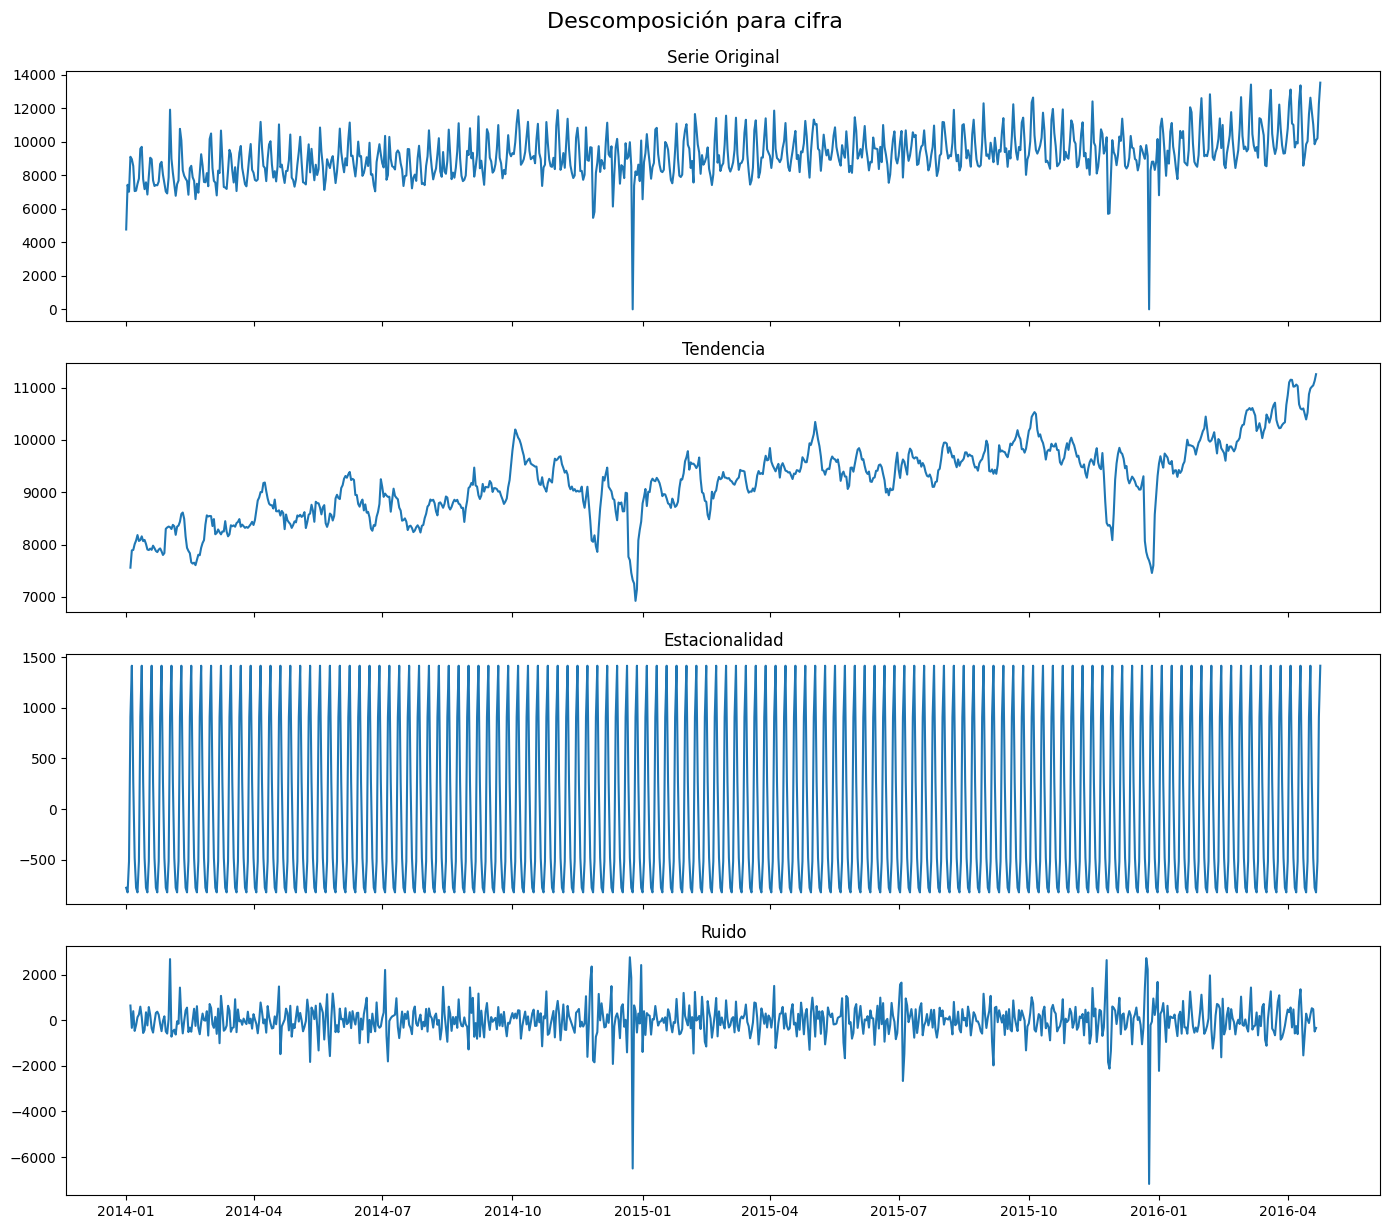

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: PHI_1
______________________________________________________________________________________________


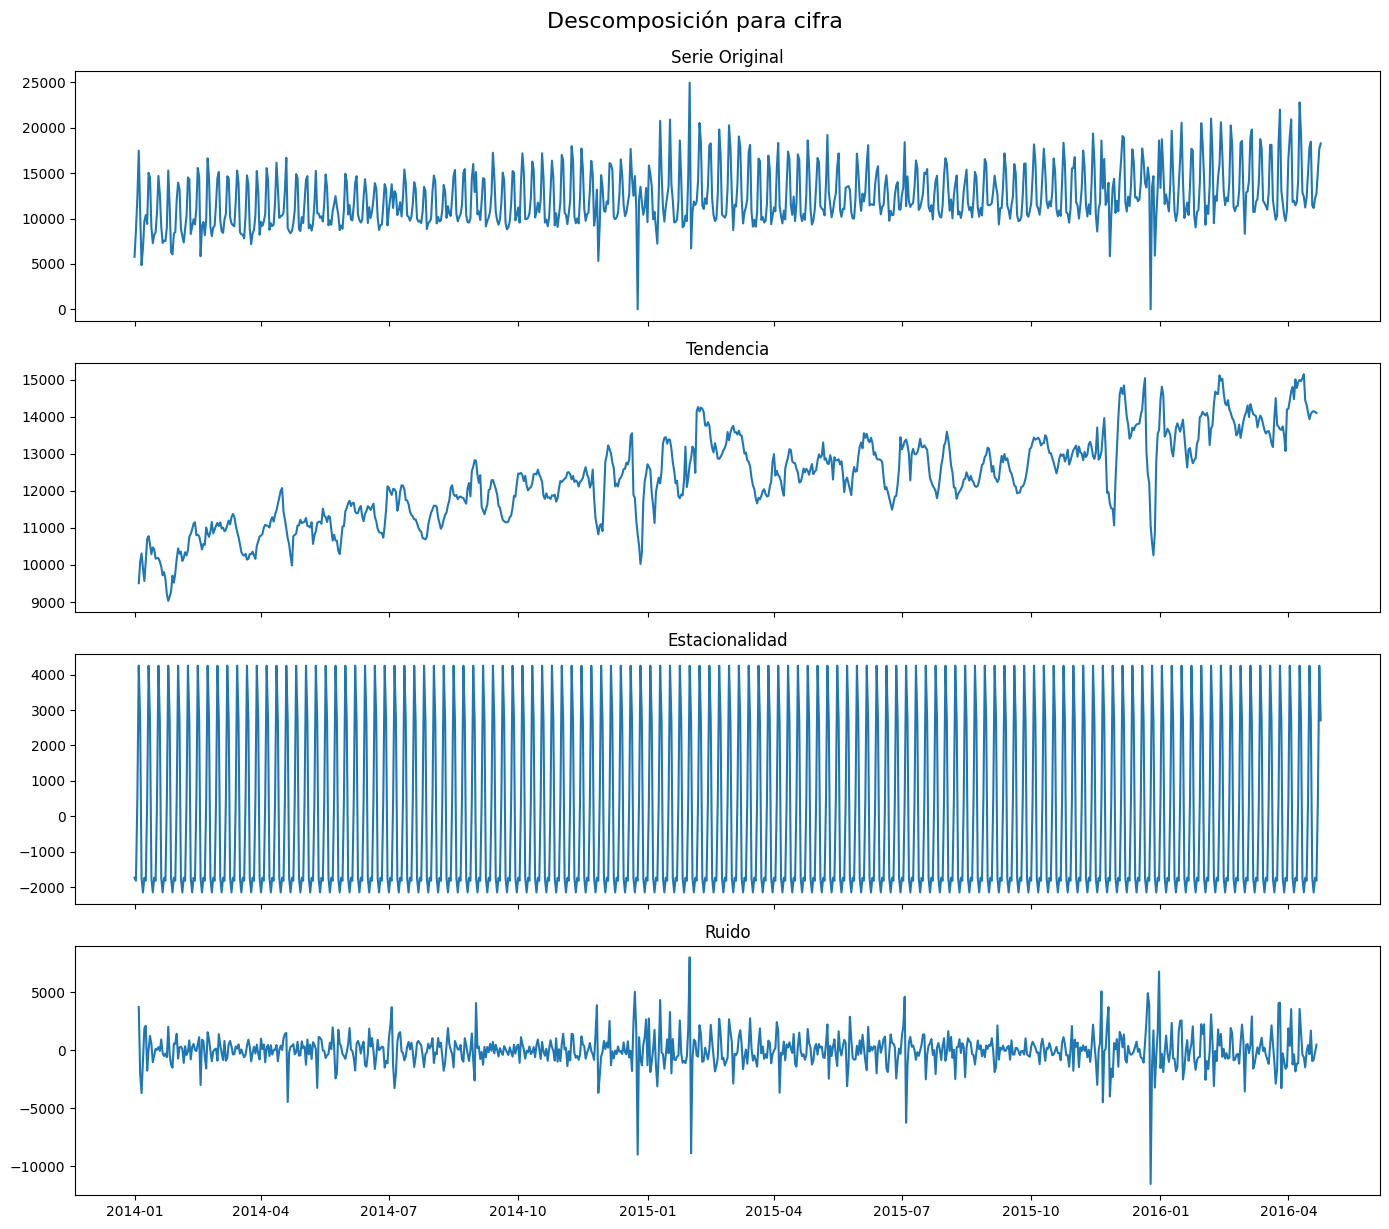

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: PHI_3
______________________________________________________________________________________________


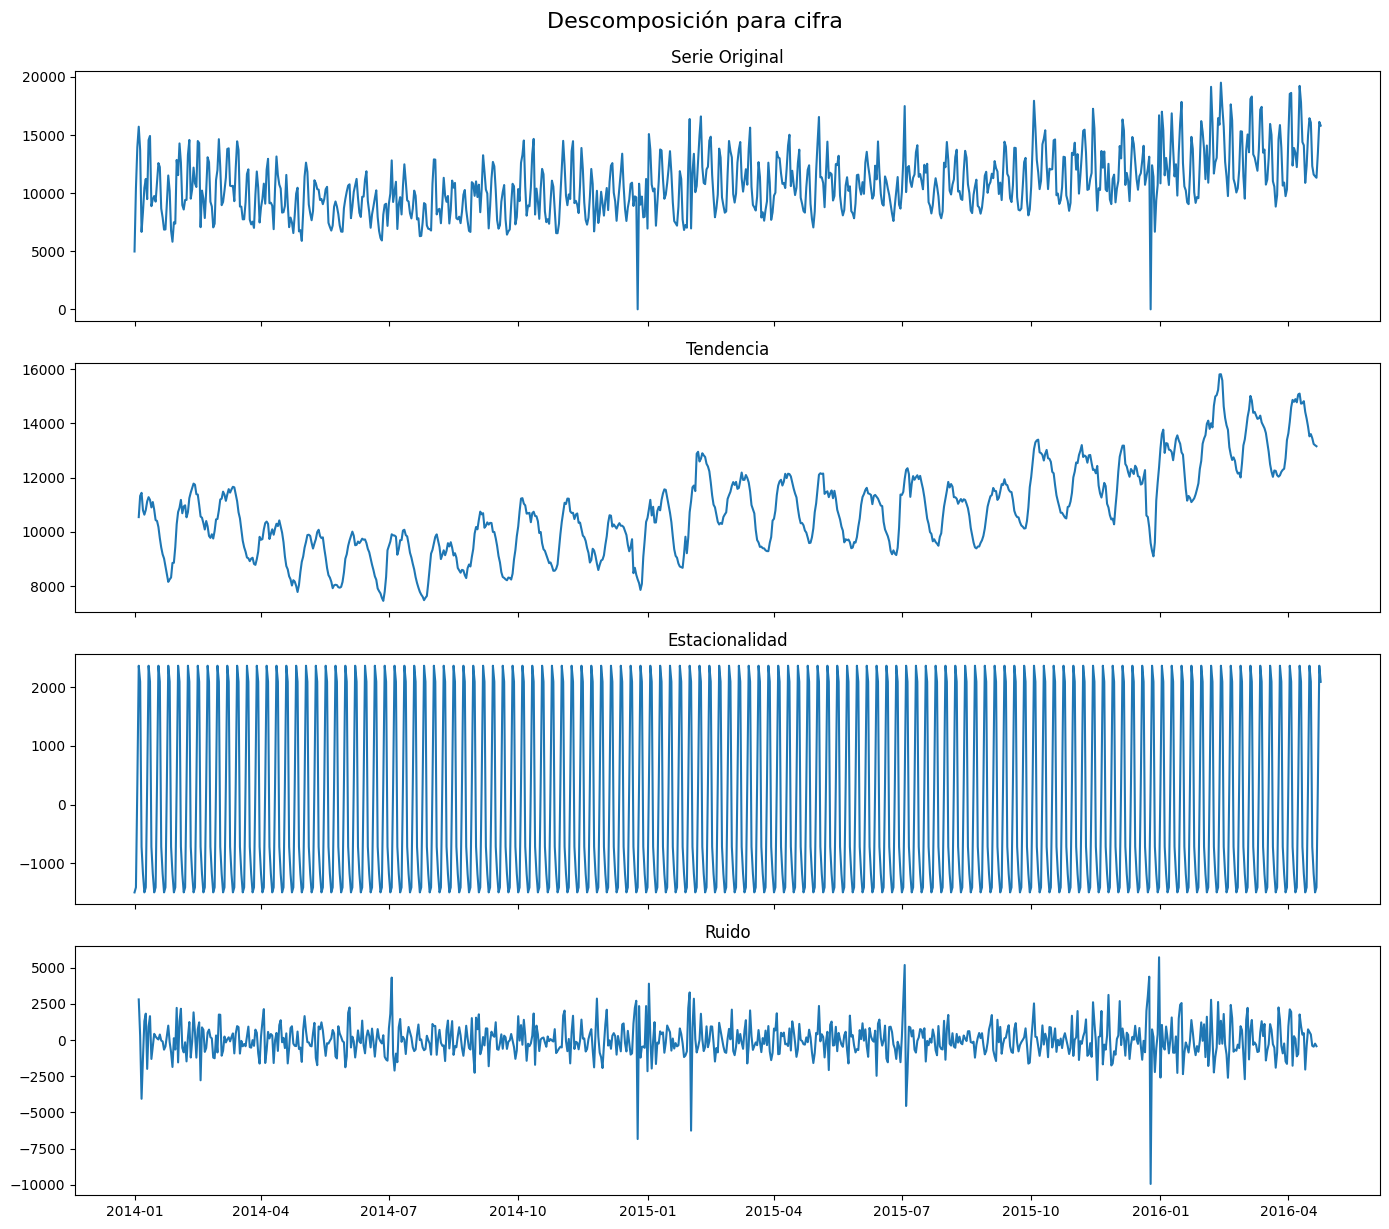

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: PHI_2
______________________________________________________________________________________________


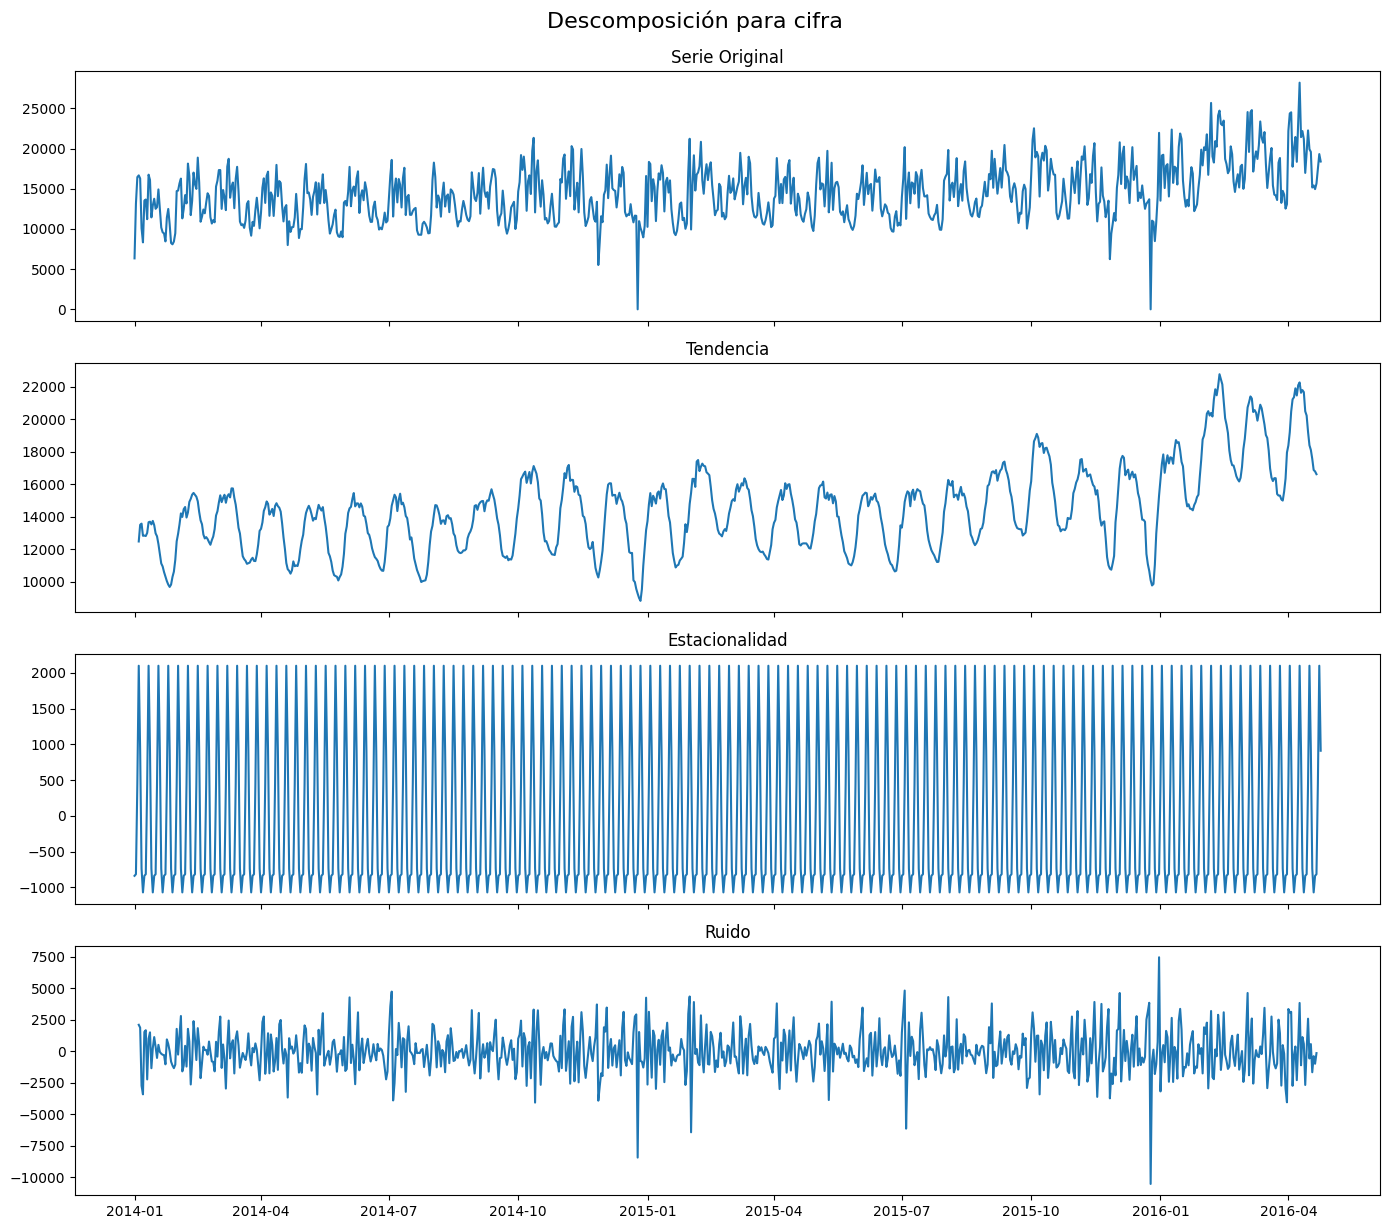

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: NYC_2
______________________________________________________________________________________________


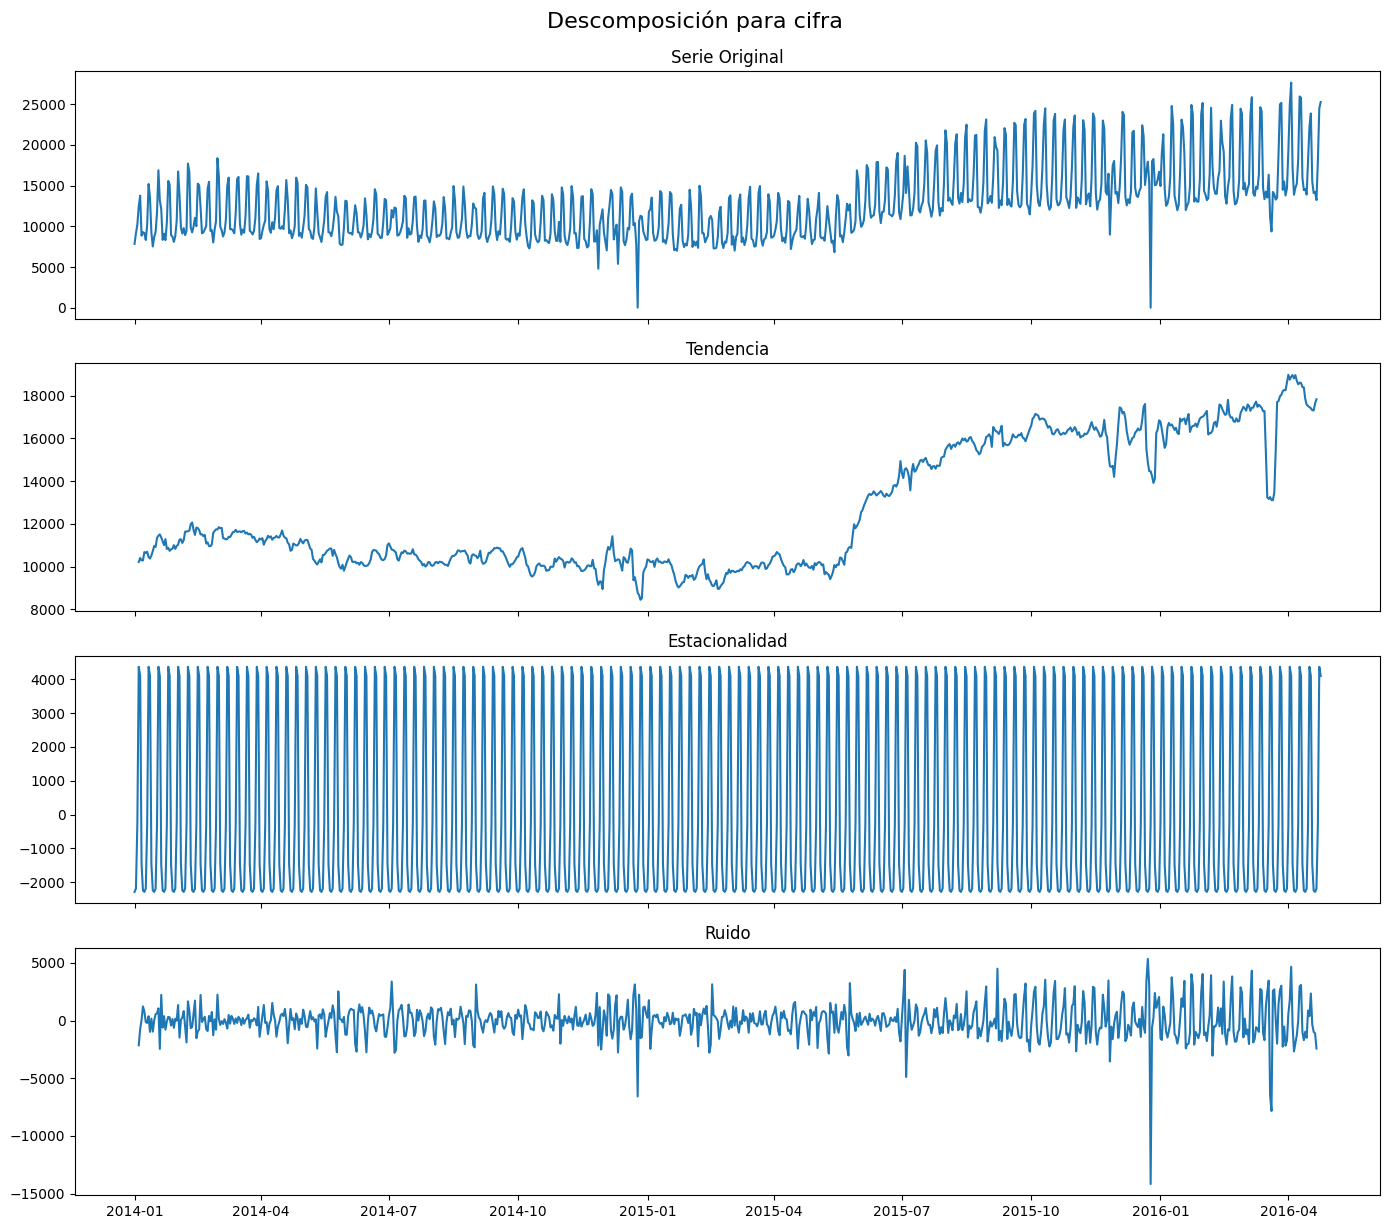

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: BOS_3
______________________________________________________________________________________________


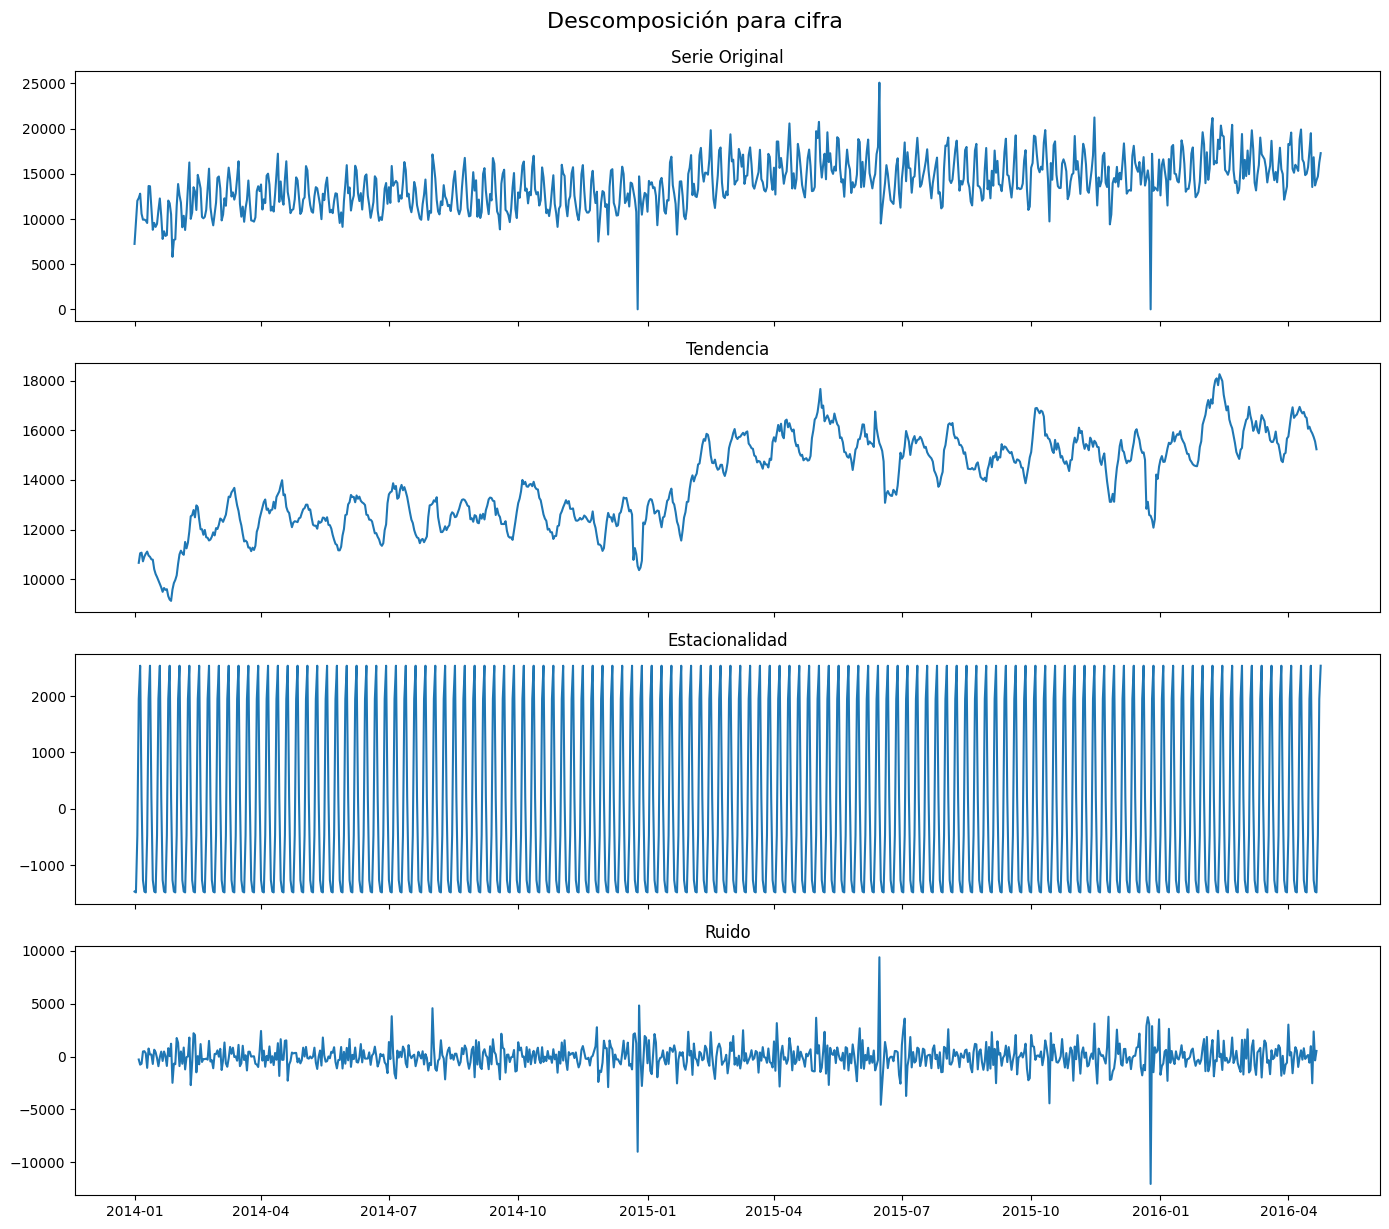

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: BOS_2
______________________________________________________________________________________________


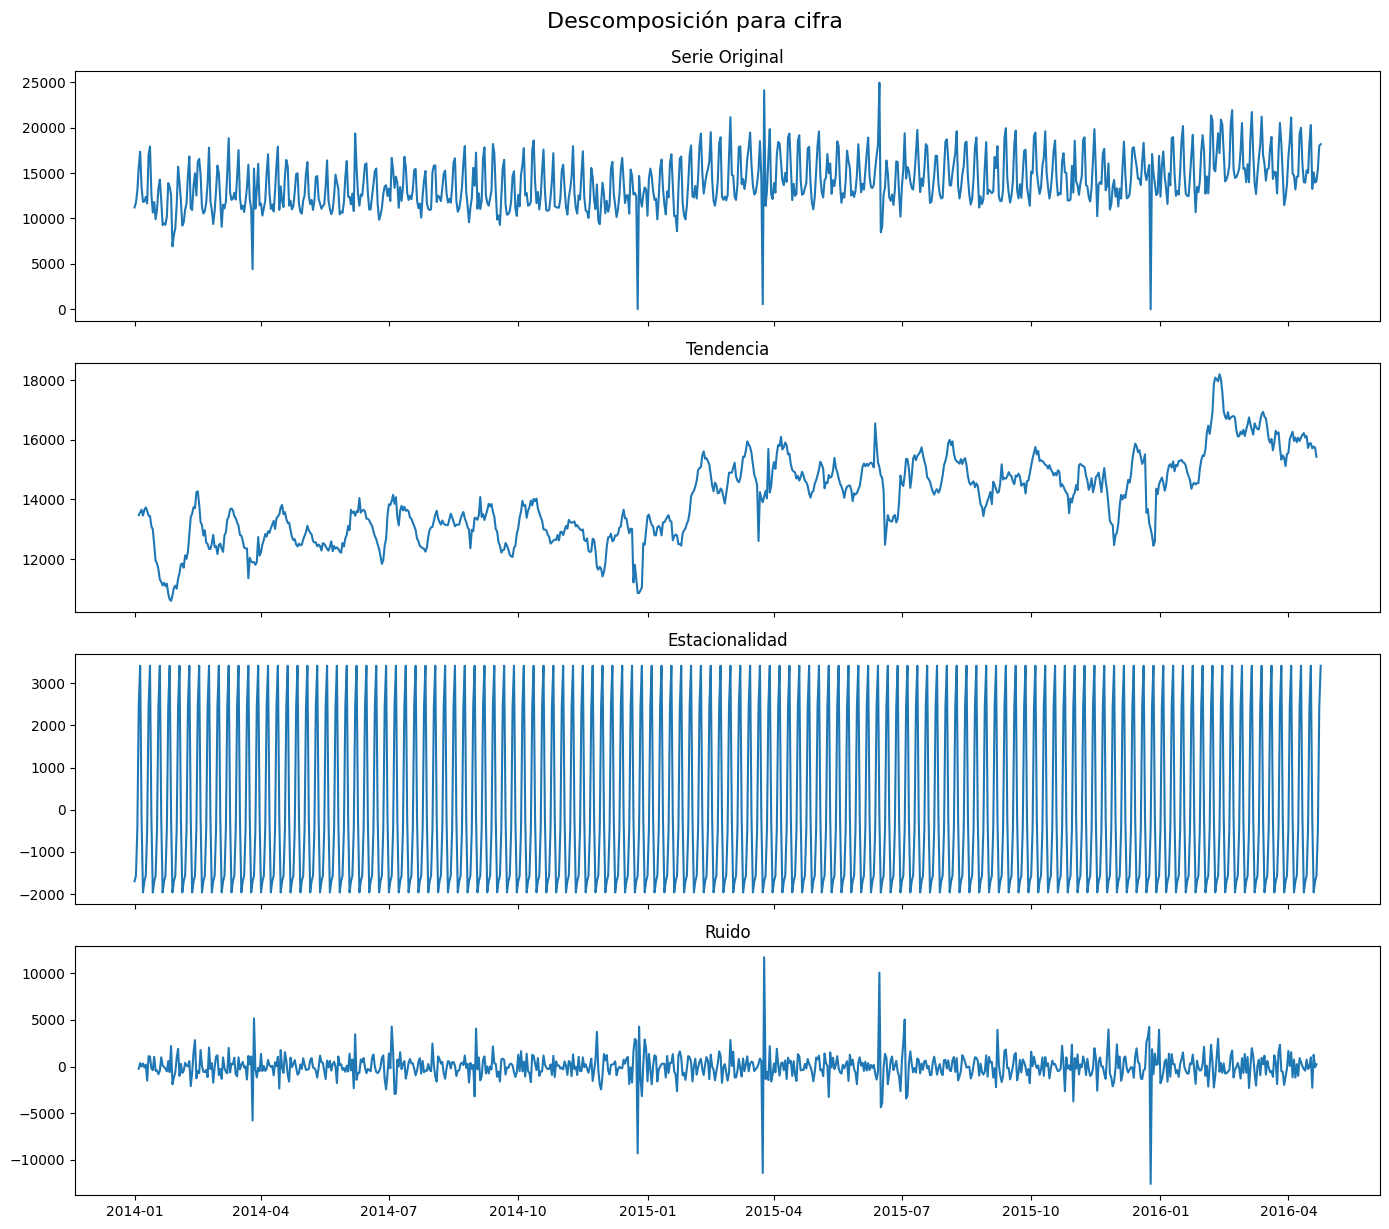

______________________________________________________________________________________________
DESCOMPOSICION para la tienda: NYC_1
______________________________________________________________________________________________


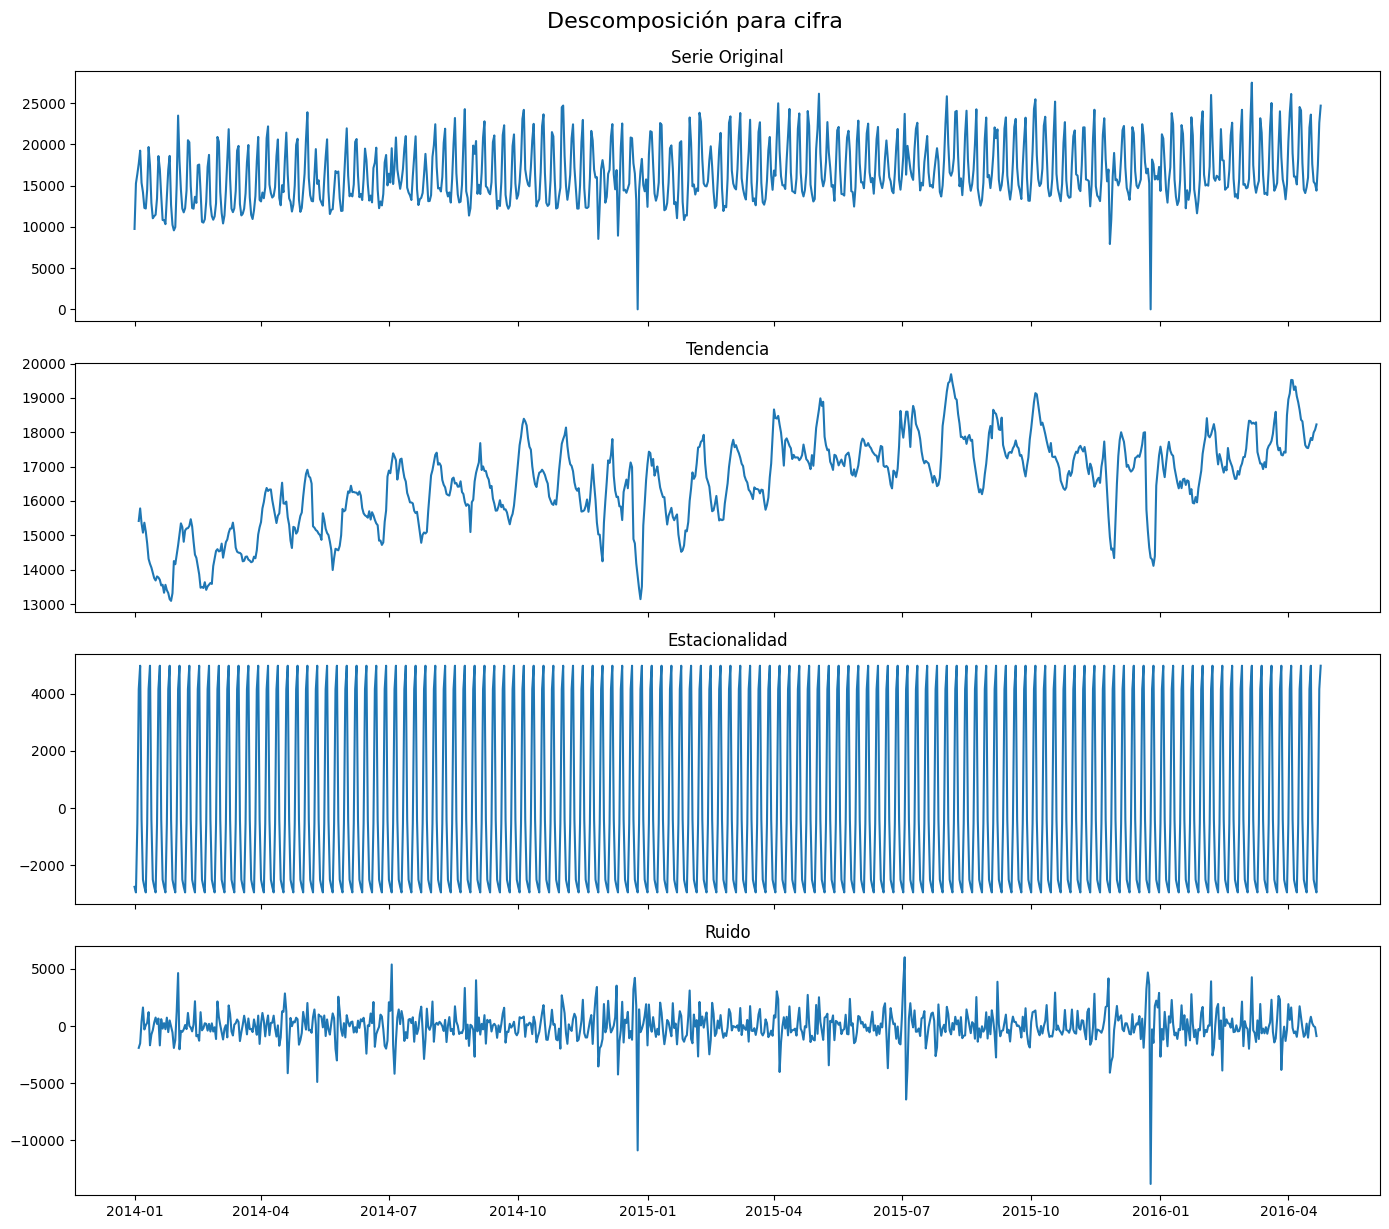

In [26]:
# Vemos graficas ventas por tiendas
# Para verlo más claro filtramos el df por tiendas
for store in store_code:
    # Filtrar por la tienda actual
    _df = tma.filter_data(df, 'store_code', store)
    
    # Llamar a la función de descomponer
    print('______________________________________________________________________________________________')
    print(f"DESCOMPOSICION para la tienda: {store}")
    print('______________________________________________________________________________________________')
    tma.decompose_time_series(_df, freq='D', model='additive', period=7)

